## import

In [1]:
#importing libraries & packages
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
import datetime
import re
import pprint
pp = pprint.PrettyPrinter(indent=4)
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

#display multiple outputs from cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [190]:
# machine learning
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

from sklearn.utils import compute_class_weight

In [3]:
# import Animal Control Incidents df
df = pd.read_csv('Animal_Control_Incidents.csv')
org_df = df.copy()

## functions

In [4]:
# regex for letters and '/' only, unless pattern reassigned
def remove_numpunc(list, pattern='[^A-Za-z,]+'):
    """regex to apply to list/df column --default: to include only letters and '/' """
    pattern = pattern
    #pattern = '[^A-Za-z_]+'
    if pattern =='[^A-Za-z,]+':
        list = [re.sub(pattern, ',', i) for i in list] 
    if pattern == '[^A-Za-z_]+':
        list = [re.sub(pattern, '', i) for i in list]
    if pattern == '[^A-Za-z/]+':
        list = [re.sub(pattern, '/', i) for i in list]
    if pattern == '[^0-9]+':
        list = [re.sub(pattern, '', i) for i in list]
    return list

In [5]:
# str type, eliminate misplaced whitespace, lower casing, replacing blankspace with '_'
def clean_str(col):
    
    df[col] = df[col].astype(str, skipna=True)
    df[col] = df[col].str.strip()
    df[col] = df[col].apply(lambda x: x.replace(' ', '_'))
    df[col] = df[col].str.lower()

In [6]:
# this returns sub value counts of df with threshold of value counts

# dups = df.groupby('color').filter(lambda x: x.color.value_counts().max() < 2)
# dups.color.value_counts()

# not sure which is better

# dups = df[~df.duplicated(['color'], keep=False).groupby(df['color']).transform('sum').ge(100)]
# dups.color.value_counts()

In [7]:
# plotting counts of timedate data 
def plot_dtcount(td_df, col, limitsy = None, limitsx= None, overlap = True, labels = None):
    """Plots incident count(y) with timeframe as x axis:
    
        td_df = dataframe with date/time
        col = date/time column(s) of dataframe to plot counts
        limitsy= (y,y), limitsx= (x,x) can be adjusted
         -, helful if wanting to exclude extreme outliers -
         overlap= boolean(if looping and want plots seperately plotted, set to False)
         labels= str or list of str for legend
         """
    
    td_df[col] = td_df[col].dropna()
    time_c = td_df.groupby([col])[col].count()
    
    if limitsy:
        plt.ylim(limitsy)
        
    if limitsx:
        plt.xlim(limitsx)

    if labels:
        plt.legend(
        (labels),
        loc='upper right'
        ,fontsize= 12)
    
    plt.scatter(time_c.index, time_c.values, s= 5, alpha=.3, label=col)
    if not overlap:
        plt.xlabel(col)
        plt.show();

In [8]:
# pretty blue/green seaborn correlation plot for categorical data
def corr_plot(data, minv=-.3, maxv=.3, dummy=True):
    """pretty blue/green seaborn correlation plot:
    
    data= dataframe(will include all columns)
    minv = -float, maxv = float  --adjust closer to 0 for more contrast, closer to -1/1 for less
    dummy = False if df is all numerical. when True:function will only dummy categorical features
    """
    
    if dummy:
        # dummy categorical features
        col_list = list(data.select_dtypes(include=['object']).columns)

        # create dummies for categorical features
        data = pd.DataFrame(pd.get_dummies(data=data,columns=col_list
                       , prefix=col_list))
    sns.set(style="white")
    corr = data.corr()

    # mask the size of covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(10, 10))

    sns.heatmap(corr, mask=mask
                ,annot=False, cmap="YlGnBu", vmin = minv, vmax=maxv, center=0,
                square=True, linewidths=.5,cbar_kws= {"shrink": .5} );
    
    #prevent the shrink of bottom row
    ax.set_ylim(len(data.columns), 0)

In [9]:
#sns countplot loop - probably unnecessary
def plot_counts(cols):
    for i, col in enumerate(cols):
       # print(df[col].value_counts())
        plt.figure(i)
        sns.countplot(y=col, data=df);

In [10]:
# replacing strings and substrings FOR COLOR COLUMN ONLY(could be made more universal)
def edit_replace(old_words, replacement_word):
    """simple replacing strings or list in the df.color column since used so frequently in editting"""
    for word in old_words:
        df['color'] = df['color'].apply(lambda x: x.replace(word, replacement_word))

# __Cleaning__

### overview

looking at size, data types, 'na's

In [11]:
df.shape

(73303, 38)

In [12]:
df.head()

,FILE NUMBER,INCIDENT DATE,INCIDENT TIME,DISPATCHED TIME,CALL TAKER,DISPATCHER,DISPATCHED OTHER,DISPATCHED SITUATION,ARRIVAL TIME,AVAILABLE TIME,...,CONDITION,TEMPERMENT,COLLAR,COLLAR COLOR,VACCINATION NUMBER,VACCINATION DATE,PET NAME,DISPOSITION,DISPOSITION DATE,DISPOSITION OFFICER
0,201639027,12/27/2016,15:30,16:06,UNKNOWN,JENNIFER G,0,D,16:17,16:38,...,FAIR,FRIENDLY,NYLON,RED,NaN,NaN,NaN,TRANS CAA,12/27/2016,FRANK S
1,201639044,12/28/2016,10:06,10:07,UNKNOWN,JENNIFER G,0,D,10:15,10:23,...,FAIR,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,RETURN TO WILD,12/28/2016,TRAVIS R
2,201639036,12/28/2016,09:03,09:03,UNKNOWN,JENNIFER G,0,D,09:27,09:45,...,EMACIATED,FRIENDLY,LEATHER,PINK,NaN,NaN,NaN,TRANS CAA,12/28/2016,ISAAC S
3,201639042,12/28/2016,09:46,10:24,UNKNOWN,JENNIFER G,0,D,10:35,10:47,...,EMACIATED,FRIENDLY,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,12/28/2016,JOHN B
4,201639059,12/28/2016,15:05,15:45,UNKNOWN,JENNIFER G,0,D,16:07,16:25,...,EMACIATED,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,12/28/2016,SUE H


In [13]:
# removing spaces and lower casing the column names
df.columns = df.columns.str.lower()
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(' ', '_')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73303 entries, 0 to 73302
Data columns (total 38 columns):
file_number             73303 non-null int64
incident_date           73303 non-null object
incident_time           72818 non-null object
dispatched_time         62547 non-null object
call_taker              53134 non-null object
dispatcher              60239 non-null object
dispatched_other        73303 non-null int64
dispatched_situation    62537 non-null object
arrival_time            61843 non-null object
available_time          62545 non-null object
complainant_street      73281 non-null object
request_type            40141 non-null object
officer                 61235 non-null object
equipment_number        60251 non-null object
remarks                 2098 non-null object
impound_number          53110 non-null float64
impound_date            53105 non-null object
impound_time            53046 non-null object
location                52867 non-null object
municipality       

Although most features are classified appropriately, some of these columns would be better described as object than int or float. There are also many dates and times to convert to datetime.

In [15]:
# # float and int columns with no numerical value
# obj_cols = ('dispatched_other', 'impound_number', 'zip_code', 'color', 'breed')

# # converting to object
# for col in obj_cols:
#     df[col] = df[col].astype(str)

Checking for duplicates:

In [16]:
# any duplicate rows?
print (len(df[df.duplicated(keep=False)])/len(df))
df[df.duplicated(keep=False)]

0.005170320450731894


,file_number,incident_date,incident_time,dispatched_time,call_taker,dispatcher,dispatched_other,dispatched_situation,arrival_time,available_time,...,condition,temperment,collar,collar_color,vaccination_number,vaccination_date,pet_name,disposition,disposition_date,disposition_officer
36519,2012224989,01/17/2012,8:16,8:49,BC,BC,0,D,9:11,9:28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,01/17/2012,NaN
36520,2012224989,01/17/2012,8:16,8:49,BC,BC,0,D,9:11,9:28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,01/17/2012,NaN
36738,2012228091,03/16/2012,10:34,13:10,NaN,BC,0,D,13:22,13:30,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,03/16/2012,SW1
36739,2012228091,03/16/2012,10:34,13:10,NaN,BC,0,D,13:22,13:30,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,03/16/2012,SW1
36862,2012231293,05/15/2012,8:32,9:27,NaN,BC,0,D,9:36,9:45,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,05/15/2012,SW1
36863,2012231293,05/15/2012,8:32,9:27,NaN,BC,0,D,9:36,9:45,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,05/15/2012,SW1
36864,2012231293,05/15/2012,8:32,9:27,NaN,BC,0,D,9:36,9:45,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,05/15/2012,SW1
36865,2012231293,05/15/2012,8:32,9:27,NaN,BC,0,D,9:36,9:45,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,05/15/2012,SW1
37062,2012226886,02/22/2012,17:4,NaN,TR,NaN,0,NaN,NaN,NaN,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,02/22/2012,SW1
37063,2012226886,02/22/2012,17:4,NaN,TR,NaN,0,NaN,NaN,NaN,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,02/22/2012,SW1


In [17]:
#sorting by rows with most nas
df = df.iloc[df.isnull().sum(axis=1).mul(-1).argsort()]


# removing duplicate rows from df - likely data entry mistakes
df.drop_duplicates(keep='last', inplace=True)

File numbers should all be unique to each incident. Repeated file numbers could be duplicates of the same incident with benign differences/errors.

In [18]:
# duplicate file numbers could also indicate duplicates with minor indiscretions 
print (len(df[df.duplicated(subset=['file_number','incident_date'], keep=False)])/len(df))
df[df.duplicated(subset=['file_number'], keep=False)]

0.19540340022449149


,file_number,incident_date,incident_time,dispatched_time,call_taker,dispatcher,dispatched_other,dispatched_situation,arrival_time,available_time,...,condition,temperment,collar,collar_color,vaccination_number,vaccination_date,pet_name,disposition,disposition_date,disposition_officer
59958,2013251959,04/17/2013,20:0,NaN,TP,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,04/17/2013,NaN
57842,2013256085,06/20/2013,14:25,NaN,BG,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,06/20/2013,NaN
56159,2015301479,12/06/2015,15:42,NaN,BG1,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,12/06/2015,SW1
60198,2014280818,09/21/2014,7:40,NaN,JB,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,09/21/2014,NaN
36379,2015298728,10/08/2015,8:44,9:32,NaN,NaN,0,D,NaN,9:47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,10/08/2015,NaN
58672,2012226725,02/09/2012,15:48,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,02/19/2012,NaN
57250,2012230908,05/07/2012,18:2,NaN,NaN,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,05/07/2012,NaN
41672,2014285247,12/20/2014,16:40,NaN,TR,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,12/20/2014,SW1
59167,2013248090,02/10/2013,11:15,NaN,JB,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,02/10/2013,NaN
54261,2014281408,10/01/2014,21:16,NaN,JTG,NaN,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,10/01/2014,SW1


In [19]:
# # this should drop duplicate file number rows, keeping the row with the lease nas
df = df.loc[df.notnull().sum(1).groupby(df.file_number).idxmax()]
df.drop_duplicates(subset=['file_number'], keep='last', inplace=True)

How much nas per column are there?

In [20]:
#percent missing values per column
round(df.isna().sum()/len(df)*100)

file_number              0.0
incident_date            0.0
incident_time            1.0
dispatched_time         13.0
call_taker              28.0
dispatcher              16.0
dispatched_other         0.0
dispatched_situation    13.0
arrival_time            14.0
available_time          13.0
complainant_street       0.0
request_type            43.0
officer                 17.0
equipment_number        16.0
remarks                 98.0
impound_number          32.0
impound_date            32.0
impound_time            32.0
location                32.0
municipality            32.0
zip_code                69.0
service_code            32.0
species                 32.0
breed                   33.0
sex                     48.0
size                    33.0
color                   33.0
age                     57.0
condition               35.0
temperment              34.0
collar                  68.0
collar_color            68.0
vaccination_number      99.0
vaccination_date        99.0
pet_name      

Since most features are missing substantial amounts of data, I want to be careful about dropping nas to avoid tossing out useful information with the nulls.

In [21]:
# removing columns with 90%+ missing:
df.drop(columns=['remarks', 'vaccination_number', 'vaccination_date', 'collar', 'collar_color', 'pet_name'
                ,'file_number']
        , inplace=True)

In [22]:
#removing row with nas from incident time since such little nas(1% rows)
df = df[df['incident_time'].notna()]

### unimportant

I'll start by investigating the features I feel are not going to be useful, or have too many nas

#### age, sex

these features are both missing roughly 50%

In [23]:
df.age.value_counts()/df.age.value_counts().sum()

0.0     0.995040
2.0     0.000992
3.0     0.000735
5.0     0.000735
4.0     0.000441
1.0     0.000367
6.0     0.000257
7.0     0.000220
9.0     0.000220
8.0     0.000220
10.0    0.000184
13.0    0.000147
12.0    0.000110
11.0    0.000073
14.0    0.000073
16.0    0.000073
15.0    0.000073
17.0    0.000037
Name: age, dtype: float64

I'm having a hard time believing that 99% of the animals were 0 years old. I will be excluding this column. 

In [24]:
df.drop(columns=['age'], inplace=True)

In [25]:
df.sex.value_counts()/df.sex.value_counts().sum()

M    0.351869
U    0.351206
F    0.296685
1    0.000060
D    0.000060
0    0.000030
S    0.000030
N    0.000030
K    0.000030
Name: sex, dtype: float64

In [26]:
df.drop(columns=['sex'], inplace=True)

#### names

In [27]:
name_cols = ['call_taker', 'dispatcher', 'officer', 'disposition_officer'] 

In [28]:

for col in name_cols:
    clean_str(col)
    df[col] = remove_numpunc(df[col], pattern='[^A-Za-z_]+')        

In [29]:
for col in name_cols:
    df[col].value_counts()

unknown       28129
nan           17415
jennifer_g     5920
bc             2411
john_b         1076
bg              884
tr              830
is              758
daniel_p        660
jc              649
tz              558
jb              532
jtg             488
sb              452
jg              408
tp              401
sedwin_b        373
rt              360
fs              198
law             188
ms              160
wb              129
richard_b       103
ac               81
rosemary_a       54
lw               49
sr               43
dp               36
sh               33
joey_g           30
ic               29
sw               14
jpb              13
                  8
jason_c           8
sue_h             7
isaac_s           6
travis_r          5
jeg               4
frank_s           4
anna_c            3
jw                3
mg                3
tf                2
bjg               2
llaw              1
je                1
aa                1
djp               1
jeb               1


jennifer_g    33323
bc            17200
nan            9800
unknown         859
john_b          745
richard_b       722
sedwin_b        600
jtg             138
joey_g          131
bg                5
is                4
rt                2
tp                1
isaac_s           1
passpp            1
                  1
Name: dispatcher, dtype: int64

nan           10674
unknown        9012
frank_s        4167
anna_c         3774
travis_r       3249
jason_c        2994
tr             2943
john_b         2766
jb             2609
bg             2544
sue_h          2415
isaac_s        2116
sb             1764
sedwin_b       1737
lw             1219
is              818
fs              778
jc              675
jtg             656
tz              604
allison_c       599
dd              576
jennifer_g      494
tp              453
mg              451
jg              434
rt              401
jw              337
kd              311
joey_g          295
              ...  
sh               33
hilton_c         31
sw               17
jpb              13
brent_g          11
bc                5
hc                5
                  5
susan_w           4
jeg               4
suzie_b           3
kjg               2
bjg               2
btg               2
bj                1
abg               1
djp               1
tis               1
dr                1


nan           20739
sw            15508
sb             4469
ph             2763
frank_s        2105
anna_c         2062
jl             1999
travis_r       1678
john_b         1497
jason_c        1404
allison_c      1243
lw             1208
sue_h          1136
sedwin_b       1044
isaac_s        1031
jtg             809
dd              680
kd              419
djp             262
jw              204
joey_g          134
tim_z           130
bg              100
tr               97
jg               87
tp               82
rt               80
is               79
jb               65
susan_w          55
              ...  
ms               40
kw               35
patty_h          28
suzie_b          12
hilton_c          8
ic                7
law               5
rosemary_a        5
jennifer_g        3
ab                2
richard_b         2
dp                2
jrl               2
swi               2
bmg               2
yr                1
pg                1
p_h               1
jrg               1


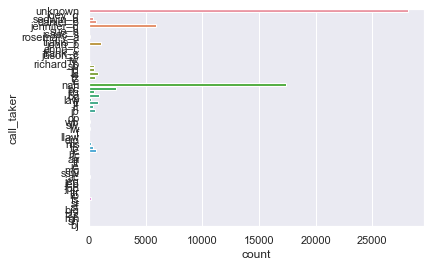

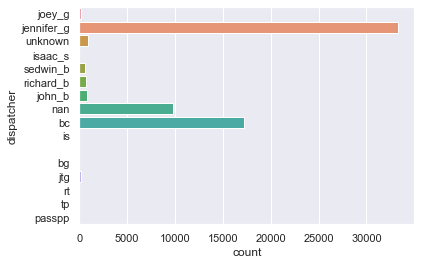

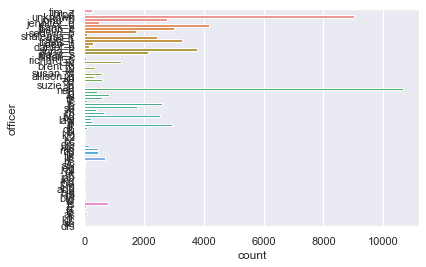

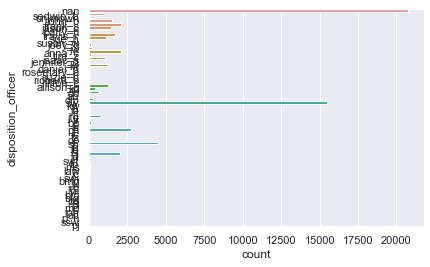

In [30]:
plot_counts(name_cols)

they're all very imbalanced, but dispatcher is the only one that doesn't look insanely messy.

If I was able to consult someone of knowledge at the baton rouge animal control facility, I would be able to sort out the names better(i.e. are any of the initials representative of the given full names, 

Below, I'm iterating through name columns to see how many days each unique name shows, and how many unique names show per day:  

Basically, 
- how many employees per position do they have on staff per day* &
-  how many days has that employee worked in that role(over the span of 6 years).*

*_(If we were to assume that daily, all workers had their names on at least one report in respective column)_

In [31]:
for col in name_cols:
# df with incident time and position dropping nas
    df2 = df[['incident_date', col]].dropna().reset_index()

# grouping df by unique count of worker in position per day
# then seeing how many days they have each given number of dispatchers
    print ('\nnumber of',col,'/ number of days\n',df2.groupby('incident_date')[col].nunique().value_counts())
# how many days does each employee position appear on indicent report
#    df3 = df[['incident_date', col]].dropna().reset_index()

#    print (' employee/ number of days worked')df3.groupby(col)['incident_date'].nunique())


number of call_taker / number of days
 3     724
2     614
4     514
5     242
1     197
6     104
7      64
8      22
9      11
10      5
11      2
Name: call_taker, dtype: int64

number of dispatcher / number of days
 1    1322
2    1163
3      13
4       1
Name: dispatcher, dtype: int64

number of officer / number of days
 7     390
6     356
5     340
8     304
4     288
3     265
9     160
2     153
10    106
1      69
11     45
12     19
13      4
Name: officer, dtype: int64

number of disposition_officer / number of days
 2     770
3     397
1     246
8     216
7     212
9     161
4     153
6     144
5      85
10     83
11     26
12      4
13      2
Name: disposition_officer, dtype: int64


if the above assumption were verified, it would appear:
- most often there are 1-3 call takers on staff, almost always between 1-5
- 1 dispatcher per day, very rarely 2 or 3, or could be data entry error
- usually 3-4, or between 1 and 7 officers
- usually 2 disposition officers, or between 1 and 4

In [32]:
df.drop(columns = name_cols, inplace=True)

#### equipment number

ID of the vehicle sent to the incident location

In [33]:
df.equipment_number.value_counts()

AC04     5555
AC12     5380
AC09     5378
AC13     4850
AC10     4409
AC06     4270
AC11     4198
AC19     4039
AC18     3386
AC01     3249
AC16     3124
AC15     2493
AC14     1466
AC20      186
19        115
12        100
AC9        77
15         77
4          73
AC6        71
11         62
10         59
13         58
14         55
09         50
AC4        49
9          41
AC05       37
1          37
16         36
         ... 
06         14
AC 19      13
04         11
AC 9       10
AC 4        9
AC08        7
AC 1        7
AC 8        6
AC 18       6
AC 6        5
AC 13       5
18          4
AC 14       4
AC 20       3
5           3
AC 12       3
17          3
AC5         2
AC-14       2
AC 15       1
AC198       1
4C18        1
SC          1
2692        1
AC-4        1
AC- 4       1
AC016       1
ZAC14       1
AC-10       1
AC 7        1
Name: equipment_number, Length: 67, dtype: int64

In [34]:
clean_str('equipment_number')

In [35]:
df['equipment_number'] = remove_numpunc(df['equipment_number'], pattern ='[^0-9]+')

In [36]:
df['equipment_number'] = df['equipment_number'].apply(lambda x : x[1:] if x.startswith("0") else x)

In [37]:
df['equipment_number'] = df.equipment_number.replace('2692', 'nan')
df['equipment_number'] = df.equipment_number.replace('198', 'nan')
df['equipment_number'] = df.equipment_number.replace('418', 'nan')
df['equipment_number'] = df['equipment_number'].apply(lambda x : x.replace(x,'nan') if x=='' else x)

In [38]:
# df['equipment_number'] = df['equipment_number'].astype(object)

# df['equipment_number'] =df['equipment_number'] = df['equipment_number'].apply(lambda x : x.replace(x,NaN) if x=='nan' else x)

In [39]:
df.equipment_number.value_counts()

nan    10249
4       5699
9       5556
12      5483
13      4913
10      4484
6       4393
11      4282
19      4167
18      3396
1       3344
16      3161
15      2571
14      1528
20       189
5         42
7         35
17        28
8         13
Name: equipment_number, dtype: int64

#### impound_number

Number used to track animals being impounded into shelter.

In [40]:
df.impound_number.value_counts()

0.0        20
46757.0     2
36155.0     2
24181.0     2
42765.0     2
20866.0     2
24164.0     2
64540.0     2
58487.0     2
26043.0     2
24941.0     2
27535.0     2
41801.0     2
61184.0     2
52488.0     2
24290.0     2
30292.0     2
26970.0     2
27288.0     2
35637.0     2
24267.0     2
59758.0     2
29797.0     2
40689.0     2
20057.0     2
23447.0     2
38486.0     2
53254.0     2
63752.0     2
38399.0     2
           ..
79168.0     1
88590.0     1
81436.0     1
51477.0     1
22195.0     1
47900.0     1
79167.0     1
45034.0     1
79170.0     1
43841.0     1
91070.0     1
59834.0     1
94533.0     1
85466.0     1
57858.0     1
79713.0     1
79173.0     1
35835.0     1
59778.0     1
57993.0     1
76064.0     1
79172.0     1
76071.0     1
42459.0     1
79043.0     1
42190.0     1
90065.0     1
79171.0     1
79071.0     1
90112.0     1
Name: impound_number, Length: 43268, dtype: int64

I'm not sure if the duplicate impound numbers are due to data errors, but the ones that are 0.0 I feel more confident are mistakes. 

In [41]:
# what do the 0 impound number rows look like
df[ df['impound_number'] == 0.0 ]

#df = df[ df['impound_number'] != 0.0 ]

,incident_date,incident_time,dispatched_time,dispatched_other,dispatched_situation,arrival_time,available_time,complainant_street,request_type,equipment_number,...,zip_code,service_code,species,breed,size,color,condition,temperment,disposition,disposition_date
63860,05/03/2012,8:19,9:4,0,D,9:28,9:43,ELLIOT RD,NaN,19,...,NaN,TRAPPED ANIMAL,WILDLIFE,OTHER,MEDIUM,RED,NaN,NaN,RETURN TO WILD,05/04/2012
64630,07/17/2012,9:7,9:11,0,D,9:36,9:37,FRONTIER DR,NaN,1,...,NaN,TRAPPED ANIMAL,WILDLIFE,SQUIRREL,SMALL,NaN,FAIR,NERVOUS,RETURN TO WILD,07/17/2012
58310,08/14/2012,9:55,NaN,0,NaN,NaN,NaN,GIBBENS,NaN,nan,...,NaN,STRAY AN. SECURED,CAT,DSH,SMALL,GRY/BLK/BRWN,FAIR,NORMAL,TRANS CAA,08/15/2012
53784,10/07/2012,13:41,NaN,1,NaN,NaN,NaN,SKYSKAIL,NaN,12,...,NaN,STRAY,DOG,XDACHSHUND,MEDIUM,BRIN BLK WHT,FAIR,NERVOUS,TRANS CAA,10/08/2012
49239,12/28/2012,8:27,9:10,0,D,9:19,9:28,HAVENWOOD DR,NaN,11,...,NaN,TRAPPED ANIMAL,WILDLIFE,POSSUM,MEDIUM,WHT/GRY,FAIR,NORMAL,RETURN TO WILD,12/28/2012
35998,02/19/2013,9:56,10:21,0,D,10:34,10:44,SHERWOOD FOREST DR,NaN,6,...,NaN,TRAPPED ANIMAL,CAT,DSH,LARGE,BLK/WHT,FAIR,NERVOUS,TRANS CAA,02/19/2013
49179,05/01/2013,12:33,13:22,0,D,13:31,13:46,MADISON AV,NaN,12,...,NaN,TRAPPED ANIMAL,WILDLIFE,POSSUM,MEDIUM,GREY,FAIR,NORMAL,RETURN TO WILD,05/01/2013
38545,07/09/2013,8:36,8:54,0,D,9:18,9:47,CRESTVIEW AV,NaN,1,...,NaN,STRAY,DOG,ROTTWEILLER,MEDIUM,BLK/TAN,FAIR,NORMAL,TRANS CAA,07/10/2013
53032,08/01/2013,9:47,10:16,0,D,10:36,10:44,OAKMOUNT DR,NaN,15,...,NaN,TRAPPED ANIMAL,WILDLIFE,RACCOON,LARGE,BRN/BLK,FAIR,NORMAL,RETURN TO WILD,08/01/2013
69585,11/24/2013,18:6,NaN,0,NaN,NaN,NaN,CHERRY BARK,NaN,4,...,NaN,TRAPPED ANIMAL,WILDLIFE,POSSUM,EXTRA LARGE,GREY,FAIR,NORMAL,RETURN TO WILD,11/24/2013


In [42]:
# replacing '0.0' impound with NaT
df.loc[df['impound_number'] == 0.0, 'impound_number'] = np.NaN

In [43]:
#print (len(df[df.duplicated(subset=['file_number','incident_date'], keep=False)])/len(df))
df[df.duplicated(subset=['impound_number'], keep=False)]

,incident_date,incident_time,dispatched_time,dispatched_other,dispatched_situation,arrival_time,available_time,complainant_street,request_type,equipment_number,...,zip_code,service_code,species,breed,size,color,condition,temperment,disposition,disposition_date
28371,05/02/2016,06:03,08:52,0,D,09:07,09:17,AVENUE C ST,PATROL AREA,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28329,05/02/2016,06:04,09:18,0,D,09:33,09:51,TRUMAN ST,CRUELTY RECHECK,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28277,05/02/2016,06:06,08:26,0,D,08:45,08:53,CHARLES ST,PATROL AREA,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3060,05/02/2016,06:15,00:00,0,K,00:00,00:00,HUNTERS TRAIL DR,OTHER,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28255,05/02/2016,06:18,09:51,0,D,10:09,10:11,SAUL AV,CRUELTY RECHECK,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2196,05/02/2016,06:19,13:38,0,D,14:34,14:34,WILLIAMS RD,CRUELTY RECHECK,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28251,05/02/2016,06:23,08:27,0,D,08:47,08:51,PLAZA DR,CRUELTY RECHECK,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3050,05/02/2016,06:23,10:14,0,D,10:14,10:33,O'NEAL LN,DELIVERED TAGS,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3168,05/02/2016,06:24,08:39,0,D,08:45,08:48,PLANK RD,DELIVERED TAGS,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
891,05/02/2016,07:28,08:28,0,D,08:58,09:10,ORLANDO DR,PICK UP TRAP,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I don't notice any rows that look similar enough to be considered duplicates. However, I don't see this feature being useful for me.

In [44]:
df.drop(columns=['impound_number'], inplace=True)

#### dispatched situation, dispatched other

- __dispatched situation:__ Indicates if officer was dispatched (D) or the call had to be postponed (K) and addressed the following day. ( _data source does not explain U,F, or N_ )


- __dispatched_other:__ Not dispatched by cad but there is dispatch info in record



In [45]:
for col in ('dispatched_situation', 'dispatched_other'):
    df[col].value_counts()

D    51144
K     4566
U      155
F        5
N        1
Name: dispatched_situation, dtype: int64

0    62337
1     1196
Name: dispatched_other, dtype: int64

In [46]:
# won't be needing these
df.drop(columns=['dispatched_situation', 'dispatched_other'], inplace=True)

#### service code, request type (service_type)

In [47]:
sr = ('service_code', 'request_type')

In [48]:
for col in sr:
    print('--',col.capitalize(),'--\n',df[col].value_counts(),'\n')

-- Service_code --
 TRAPPED ANIMAL           16254
STRAY                     6694
STRAY AN. SECURED         3703
STRAY AN SECURED          2186
LOOSE                     2078
INJURED                   1934
OWNER SIGNED RELEASE      1441
ABANDONED ANIMAL          1235
WILD LIVE                 1222
BITE CASE LOOSE            842
SICK ANIMAL                779
UNIT STANDING BY           772
ANIMAL RESCUE              727
CRUELTY                    600
VET PICKUP                 510
BITE CASE SECURE           427
DANGEROUS ANIMAL SIT.      354
SNAKE                      335
DANGEROUS ANIMAL SIT       279
SCHOOL CALL                242
LOOSE LIVESTOCK            242
UNKNOWN                    228
SPECIAL CASE               132
BITE CASE                  106
DOG FIGHTING                13
OWNED                        4
HIT BY CAR                   1
Name: service_code, dtype: int64 

-- Request_type --
 UNKNOWN                       6405
TRAPPED ANIMAL                5737
STRAY             

In [49]:
# creating column that fills in missing values from service code using existing values from request type
df['service_type']=df['service_code'].mask(pd.isnull, df['request_type'])

# dropping merged columns
df.drop(columns=['service_code', 'request_type'], inplace=True)

In [50]:
# removing punctuations, lower casing, etc..
clean_str('service_type')
df['service_type'] = remove_numpunc(df['service_type'], pattern='[^A-Za-z_]+')

In [51]:
def rep_service(word, replacement):
    df['service_type'] = df['service_type'].apply(lambda x: x.replace(word, replacement))  

In [52]:
# unifying service types

# dangerous animal situation
rep_service('dangerous_animal_situation', 'dangerous_animal_sit')

# cruelty cases
rep_service('cruelty_case', 'cruelty')

# stray animals
rep_service('stray_animal_secured', 'stray_an_secured')

#loose animal and loose could include loose livestock, so I will assign all to 'loose'
rep_service('loose_live_stock', 'loose_livestock')
rep_service('loose_livestock', 'loose')
rep_service('loose_animal', 'loose')

# injured - injured animal and injured dog all under injured
rep_service('injured_animal', 'injured')
rep_service('injured_dog', 'injured')
rep_service('hit_by_car', 'injured')

#
rep_service('delivered_tags', 'deliver_tags')

rep_service('wild_live', 'wild_life')

rep_service('other', 'unknown')

rep_service('abandoned_dog', 'abandoned_animal')
rep_service('abandoned_animal', 'abandoned')

rep_service('animal_on_school_campus', 'school_call')

rep_service('owned', 'owner_signed_release')

In [53]:
df.service_type.value_counts()

trapped_animal                16644
stray                          8771
stray_an_secured               6270
unknown                        5900
loose                          4040
injured                        2295
cruelty                        2039
abandoned                      1664
owner_signed_release           1526
wild_life                      1512
animal_rescue                  1226
deliver_tags                   1073
unit_standing_by                980
dangerous_animal_sit            962
sick_animal                     862
bite_case_loose                 842
pick_up_trap                    784
bite_case                       760
snake                           673
patrol_area                     654
pit                             618
vet_pickup                      588
cruelty_recheck                 509
special_case                    505
deliver_trap                    479
bite_case_secure                427
pick_up_or_deliver_package      349
school_call                 

### date & time

Converting dates and times to appropriate format.


#### datetime: incident and impound

- Merging incident date and time to datetime column, repeat with impound date & time.

In [54]:
# incident date + incident time for merged datetime column
df['inc_dt'] = pd.to_datetime(df['incident_date'].apply(str)+' '+df['incident_time'])

In [55]:
# impound date + impound time = impound datetime
df['imp_dt'] = pd.to_datetime(df['impound_date'].apply(str)+' '+df['impound_time'], errors ='coerce')

In [56]:
#assigning NaT to out of bounds dates and times
for col in ('inc_dt', 'imp_dt'):   
    df.loc[df[col] == datetime.time(0, 0, 0), col] = pd.NaT
    df.loc[df[col] < '2012-01-01 00:00:00 ', col] = pd.NaT

In [57]:
df.head(50)

,incident_date,incident_time,dispatched_time,arrival_time,available_time,complainant_street,equipment_number,impound_date,impound_time,location,...,breed,size,color,condition,temperment,disposition,disposition_date,service_type,inc_dt,imp_dt
28371,05/02/2016,06:03,08:52,09:07,09:17,AVENUE C ST,14,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,patrol_area,2016-05-02 06:03:00,NaT
28329,05/02/2016,06:04,09:18,09:33,09:51,TRUMAN ST,14,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cruelty_recheck,2016-05-02 06:04:00,NaT
28277,05/02/2016,06:06,08:26,08:45,08:53,CHARLES ST,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,patrol_area,2016-05-02 06:06:00,NaT
3060,05/02/2016,06:15,00:00,00:00,00:00,HUNTERS TRAIL DR,nan,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,2016-05-02 06:15:00,NaT
28640,05/02/2016,06:17,10:12,10:14,10:19,SAUL AV,14,06/04/2016,12:04,1731 38TH,...,PITBULL,LARGE,GRY WHT,UNKNOWN,UNKNOWN,TRANS CAA,06/04/2016,stray,2016-05-02 06:17:00,2016-06-04 12:04:00
28255,05/02/2016,06:18,09:51,10:09,10:11,SAUL AV,14,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cruelty_recheck,2016-05-02 06:18:00,NaT
2196,05/02/2016,06:19,13:38,14:34,14:34,WILLIAMS RD,13,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cruelty_recheck,2016-05-02 06:19:00,NaT
28251,05/02/2016,06:23,08:27,08:47,08:51,PLAZA DR,14,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cruelty_recheck,2016-05-02 06:23:00,NaT
3050,05/02/2016,06:23,10:14,10:14,10:33,O'NEAL LN,11,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deliver_tags,2016-05-02 06:23:00,NaT
3168,05/02/2016,06:24,08:39,08:45,08:48,PLANK RD,13,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deliver_tags,2016-05-02 06:24:00,NaT


In [58]:
df = df.sort_values(by='inc_dt')
df.reset_index(drop=True, inplace=True)

####  Time Features:

In [59]:
# time columns to list, then loop conversion to date.time
time_cols= [col for col in df.columns if 'time' in col]

# covert time to hour/minute datetime format
for col in time_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce', format="%H:%M").dt.time

In [60]:
for col in time_cols:
    df[col].value_counts().head(10)

08:10:00    521
08:08:00    519
08:11:00    518
08:09:00    516
08:12:00    480
08:13:00    441
08:07:00    433
08:14:00    424
08:15:00    393
08:17:00    366
Name: incident_time, dtype: int64

00:00:00    4630
09:16:00     263
09:22:00     258
09:17:00     252
09:20:00     248
09:21:00     245
09:19:00     242
09:15:00     237
09:23:00     236
09:11:00     235
Name: dispatched_time, dtype: int64

00:00:00    5642
09:21:00     259
09:22:00     251
09:23:00     244
09:19:00     242
09:20:00     240
09:25:00     238
09:13:00     238
09:16:00     237
09:24:00     237
Name: arrival_time, dtype: int64

00:00:00    4638
09:16:00     269
09:23:00     263
09:13:00     262
09:14:00     258
09:25:00     255
09:21:00     252
09:22:00     251
09:20:00     246
09:19:00     243
Name: available_time, dtype: int64

09:00:00    264
10:00:00    251
09:30:00    237
09:15:00    219
09:20:00    211
10:30:00    210
09:10:00    196
14:00:00    176
08:50:00    174
10:50:00    173
Name: impound_time, dtype: int64

there's consistently high counts around 8-10ish, although impound times highest look a little more 
The 00:00:00 is probably the default, not actual times, so I will replace with NaT.

In [61]:
# replacing '00:00:00' with NaT
for col in time_cols:
    df.loc[df[col] == datetime.time(0, 0, 0), col] = pd.NaT

In [62]:
print('Incident time Range:\n''from',df.incident_time.min(),'\n to:', df.incident_time.max())

Incident time Range:
from 00:04:00 
 to: 23:58:00


####  Date Features:

In [63]:
# all date columns to list
date_cols= [col for col in df.columns if 'date' in col]

In [64]:
# covert to month/day/year datetime format
for col in date_cols:
    df[col] = pd.to_datetime(df[col],errors='coerce', format="%m/%d/%Y")

In [65]:
for col in date_cols:
    df[col].value_counts().head(10)
    df[col].value_counts().tail(10)

2017-07-17    114
2016-11-14    114
2017-05-30    110
2016-05-31    107
2018-01-16    104
2016-07-05    103
2016-08-23    103
2016-06-06    101
2016-06-20    100
2018-01-02    100
Name: incident_date, dtype: int64

2015-07-04    1
2015-09-27    1
2012-04-29    1
2015-01-10    1
2012-03-04    1
2019-03-24    1
2015-06-20    1
2012-01-21    1
2013-12-25    1
2016-06-25    1
Name: incident_date, dtype: int64

2013-10-17    49
2013-12-02    43
2014-06-23    42
2013-10-14    41
2013-06-10    41
2013-04-29    40
2013-05-02    40
2013-07-15    40
2013-05-01    40
2013-06-24    39
Name: impound_date, dtype: int64

2015-06-20    1
2011-02-17    1
2002-02-01    1
2011-05-07    1
2016-02-21    1
2019-06-01    1
2018-11-22    1
2018-11-03    1
2018-11-25    1
2017-03-05    1
Name: impound_date, dtype: int64

2013-10-17    45
2013-12-02    43
2014-06-23    42
2013-10-14    42
2013-06-10    41
2013-09-13    41
2013-07-15    40
2012-07-13    40
2013-05-01    40
2013-07-25    39
Name: disposition_date, dtype: int64

2018-05-08    1
2018-03-01    1
2018-05-17    1
2018-04-27    1
2018-10-27    1
2011-05-07    1
2017-09-13    1
2018-10-01    1
2016-12-03    1
2017-05-09    1
Name: disposition_date, dtype: int64

In [66]:
# date range of dataset
print('Incident Date Range:\n''from:',df.incident_date.min(),'\n to:', df.incident_date.max())

Incident Date Range:
from: 2012-01-01 00:00:00 
 to: 2019-10-03 00:00:00


I noticed some dates were entered as older than 2012, which I assume was a mistake. 

In [67]:
#dates out of range to NaT
for col in date_cols:
    df.loc[df[col] < '2012-01-01 00:00:00 ', col] = pd.NaT

#df.loc[df['impound_date'] < '2012-01-01 00:00:00 ']

#### additional time features:

___
Below, I will be:


- Creating feature representing time difference between incident time and impound time.  

*_The incident date&time is when the incident was called in, the impound time is when the animal was brought to the shelter. It's possible that not every incident called in resulted in an impound, which may be the reason values are missing from impound._


__difference between datetime of incident call and impound datetime__

In [68]:
# time difference from incident to impound
df['inc_to_imp'] = df['imp_dt']-df['inc_dt']

___
Weekday and Month:

This may not provide anything insightful, but I'm creating columns for weekday and month of incident.

__- Weekday Feature-__

In [69]:
# creating day of week column:
df['weekday'] = pd.to_datetime(df['incident_date']).apply(lambda x: x.weekday())

df.weekday.value_counts()
# 0= monday

0    14073
1    12287
2    11844
3    11507
4    10528
5     1839
6     1455
Name: weekday, dtype: int64

It looks like most incidents occur on Mondays, and then dwindle down throughout the week, with much less incidents reported on weekends

Are the amount of impounds per day relative to the amount of incidents?

In [70]:
# how does incident day of week compare to impound day of week?:
imp_weekday_counts=(pd.to_datetime(df['impound_date'].dropna()).apply(lambda x: x.weekday()).value_counts())
(imp_weekday_counts.sum())/(df.weekday.value_counts().sum())
imp_weekday_counts/df.weekday.value_counts()
# 0= monday

0.6819448160798325

0    0.592056
1    0.639294
2    0.664725
3    0.671417
4    0.686075
5    1.314301
6    1.305842
dtype: float64

Something seems strange here. The dataframe has 76% of total not-null impounds to total incidents, why would there be 30% more impounds than incidents on any of the days, especially weekends?

___
__- Month feature-__

In [71]:
# column for month
df['month'] = pd.DatetimeIndex(df['incident_date']).month

df.month.value_counts()

5     6831
8     5951
6     5855
7     5769
10    5630
9     5540
4     5301
3     5143
1     4793
2     4529
11    4238
12    3953
Name: month, dtype: int64

__Warmer Climate = More Animal Control Incidents?__

May-September appear to have the most incidents. According to weather.com, the average temperature increases rises from the 50's to 60's degree Fahrenheit around min April, and then begins to dip below the 60s again towards the end of October(although Baton Rouge typically experiences the most volume in rainfall in June and August). Using that information, you can infer a positive correlation between weather and incidents, similar to the common correlation with temperature and crime.

*_Note that since the dates run between Jan-1-2012 to Oct-3rd-2019, there will be bias towards the first 10 months._

### animal features

Animals features include __color__, __breed__, __condition__, __temperment__, and __size__. color and breed present an issue with such high unique values for what should be considered , multiple spellings for the same color/breed, and alternate sequences of the same substrings appearing as different values( i.e. brown/white vs white/brown)

#### color

##### unifying spellings of colors

In [72]:
#df.color.value_counts()
df.color.value_counts()

BLK/WHT             3132
BLK                 3101
GRY                 2901
BRWN/WHT            1279
GRY/WHT             1257
TAN/WHT             1156
BRWN                1136
TAN                 1133
BLK/TAN             1033
GRAY                1006
BROWN                930
GREY                 905
GRY/BLK              793
WHT                  700
BLK/GRY              684
BLK/BRWN             635
BRWN/BLK             634
BLACK                606
BRN/BLK              602
WHT/BLK              588
ORG                  528
WHT/BRWN             519
BRINDLE              484
BRN                  450
TAN/BLK              420
WHT/TAN              410
NORMAL               373
WHT/GRY              330
WHITE                323
YELLOW               303
                    ... 
SABLE WHT              1
BRIDLE/WHT             1
NAKED                  1
BROWN/W                1
ORNAGE/WHITE           1
BRINDLE/BLUE/WHT       1
GR/TAN                 1
WHT TAN BLK GY         1
YELOW                  1


Color Feature Cleaning:

- Not liking the all caps, also unnecessary punctuation.


- 1089 unique color values is going to be a problem for machine learning models, so I'd also like to reduce those. Each color needs to have uniform spelling, and combinations with low value counts will be categorized as 'other' to reduce dimensionality and noise.

*_I'll be treating each combination as it's own category. I'm not sure if approaching each color as a separate feature would be practical, but maybe could be given more thought later. I don't see value in each individual color as much as the overall description of color(s) as a whole._

In [73]:
pre_color = df.copy()

In [74]:
df= pre_color.copy()

In [75]:
clean_str('color')

In [76]:
df['color'] = remove_numpunc(df.color, pattern = '[^A-Za-z,]+')

By looking at value counts of strings, I can decide which ones need uniform spelling. The ones with higher counts will be prioritized, and some may slip through the cracks, as it is a tedious task. Colors with strong similarity will be placed into major color categories as well, at my discretion.(ie. tan, sandy, and blonde all identified as 'tan') 

##### editting color names

In [77]:
# white: wht
whites = ('white', 'cream', 'whute', 'whit', 'whitg', 'wht','whtie'
          , 'wwht', 'what','wt','whitge','whiite','whute','shite')

edit_replace(whites, 'wht')

In [78]:
# blacks: bl
blacks = ('black', 'blk', 'blkl', 'charcoal', 'bllk', 'balck', 'blavk', 'bkl', 'vlack'
          , 'blavck', 'blkc', 'blakc')

edit_replace(blacks, 'bk')

In [79]:
# browns: br
browns = ('brown','brrwn', 'brwn', 'brn', 'choc', 'chocolate', 'brwon', 'choclate'
          , 'brw', 'brownish', 'brow', 'brnlate', 'brnish', 'brnolate', 'brnm', 'brolate'
          , 'brblk','chestnut', 'cho', 'brrwn', 'bbrown','bown')

edit_replace(browns,'br')

In [80]:
# greys: gry
greys = ('grey', 'gray', 'grrey','greymarble')

edit_replace(greys, 'gry')

In [81]:
# tans/beige/blonde: tn
tans = ('beige', 'blonde', 'golden', 'tan\\', 'goldish', 'tna', 'gold', 'tan', 'taan', 'sandy')

edit_replace(tans, 'tn')

In [82]:
# stripes: stripe_tabby
tabbies = ('tabby','tiger', 'tabble', 'taddy', 'tabs', 'tabbie')

edit_replace(tabbies, 'tab')

In [83]:
# calico = cal
edit_replace(('calico','claico'), 'cal')

In [84]:
# orange: or
oranges = ('orange', 'orn', 'copper', 'orang', 'orage', 'ornage')

edit_replace(oranges, 'org')

In [85]:
# brindle/fawn: brndl
brindles = ('brindle', 'fawn', 'merle', 'torti', 'marbled', 'tortie', 'bridle', 'brndl', 'brndle', 'brndlee','leopard', 'tortoise', 'brindlw', 'brindlde')

edit_replace(brindles, 'bndle')

In [86]:
# yellow: yel
edit_replace(('yellow','yelow','yellw', 'yell', 'ylw'), 'yel')

In [87]:
# stop words and not decribing color (* is there a better way to do this?)
to_drop = ('chest','and', 'normal', 'nose', 'paws', 'mouth', 'with', 'tail'
           , 'belly', 'head', 'ears', 'eyes', 'face', 'feet', 'color', 'standard',
          'fred', 'pattern', 'newbord', 'mostly', 'front', 'all', 'body', 'little', ' ', '  ')

edit_replace(to_drop, '')

In [88]:
# # other and unknown in nan category
# unknowns = ('unknown')

# edit_replace(unknowns, 'other')

In [89]:
# # replace empty values with other
# df['color'] = df['color'].apply(lambda x: x.strip()).replace('', 'other')

##### alphabetizing and 'other' feature for low value counts

In [90]:
df['color'] = [','.join(sorted(i.split(','))) for i in df['color']]

In [91]:
df['color'] = df['color'].apply(lambda x : x[1:] if x.startswith(",") else x)

In [92]:
# defining counts to separate at 20 value counts
counts = df['color'].value_counts()

In [93]:
# color combinations with less than 20 counts will be categorized as 'other'
other_color_df =df[df['color'].isin(counts[counts < 10].index)]

other_color_df['color'] = 'other'

In [94]:
#should be one value: 'other'
other_color_df.color.value_counts()

other    1028
Name: color, dtype: int64

In [95]:
# color values with over/equal to n counts
colors_df =df[df['color'].isin(counts[counts >= 10].index)]

In [96]:
#should be n or more per value
colors_df.color.value_counts().tail()

tab,tn           10
bk,red,wht       10
tab,wht          10
bndle,gry,wht    10
bndle,gry        10
Name: color, dtype: int64

In [97]:
#joining the 'other color' and 'all colors' dfs
df = pd.concat([colors_df,other_color_df ])

In [98]:
# # replacing unknown values
df.loc[df['color'] == 'nan', 'color'] = np.NaN
#df.loc[df['color'] == 'other', 'color'] = np.NaN
df.loc[df['color'] == 'unknown', 'color'] = np.NaN
df.loc[df['color'] == '', 'color'] = np.NaN

df.loc[df['color'] == 'tn,tn', 'color']='tn'
df.loc[df['color'] == 'wht,wht', 'color'] = 'wht'

In [183]:
#all should have a minimum n value counts, 'other' should now be included
df.color.value_counts().head(90)

AttributeError: 'DataFrame' object has no attribute 'color'

#### breed

In [100]:
pre_breed = pre_color.copy()

In [101]:
df.breed.value_counts()

DSH                               8648
POSSUM                            5340
PITBULL                           4351
RACCOON                           4250
XPIT BULL                         3326
XLABRADOR                         2125
XTERRIER                          1085
XSHEPHERD                          756
LABRADOR RETRIEVER                 746
PIT                                727
DMH                                662
GERMAN SHEPHERD                    632
DLH                                629
TERRIER                            608
XGERMAN SHEPHERD                   476
XHOUND                             436
SQUIRREL                           392
CHIHUAHUA                          340
OTHER                              310
XCHIHUAHUA                         291
ARMADILLO                          284
SHIH TZU                           277
ROTTWEILLER                        261
HORSE                              254
XROTTWEILER                        229
XBOXER                   

 *_DSH=Domestic Short Hair, DMH= Domestic Medium Hair, and DLH=Domestic Long Hair_

In [102]:
df['breed'] = df['breed'].apply(lambda x : x[1:] if str(x).startswith("X") else x)

In [103]:
clean_str('breed')

In [104]:
df['breed'] = df.breed.apply(lambda x: x.replace('__', '_'))

df['breed'] = remove_numpunc(df['breed'], pattern='[^A-Za-z_]+')

*_some of these breeds sound very similar(ie. staffordshire bull terrier vs american staffordshire terrier, doberman vs doberman pinscher, but I have investigated the questionably similar breeds before reassigning to the same variable._

In [105]:
def rep_breed(word, replacement):
    df['breed'] = df['breed'].apply(lambda x: x.replace(word, replacement)) 

In [106]:
# replacing breed names 
rep_breed('chow_chow', 'chow')
rep_breed('boston_terrier', 'boston')
rep_breed('poodle_standard', 'poodle')
rep_breed('basset_hound', 'basset')
rep_breed('rottweiller', 'rott')
rep_breed('rottweiler', 'rott')
rep_breed('pit_bull', 'pitbull')
rep_breed('pitbull', 'pit')
rep_breed('labrador_retriever', 'labrador')
rep_breed('catahoula_hound', 'catahoula')
rep_breed('english_bulldog', 'bulldog_english')
rep_breed('shar_pei', 'sharpei')
rep_breed('brittany_spaniel', 'brittany')
rep_breed('other', 'unknown')

In [107]:
df.loc[df['breed'] == 'nan', 'breed'] = np.NaN

In [108]:
#len(df.breed.value_counts())
df.breed.value_counts()

dsh                               8648
pit                               8407
possum                            5340
raccoon                           4250
labrador                          2871
terrier                           1693
german_shepherd                   1230
shepherd                           829
dmh                                662
chihuahua                          631
dlh                                629
hound                              545
rott                               490
squirrel                           392
boxer                              384
unknown                            384
armadillo                          284
shih_tzu                           277
beagle                             267
horse                              254
chow                               252
catahoula                          250
dachshund                          195
retriever                          185
mixed                              167
husky                    

#### condition, disposition, size, species, temperment

In [109]:
cdsst ='species', 'size', 'condition', 'temperment', 'disposition'

In [110]:
for col in cdsst:
    clean_str(col)
    df[col] = remove_numpunc(df[col], pattern='[^A-Za-z_]+')

In [111]:
for col in cdsst:
    df.loc[df[col] == 'nan', col] = np.NaN
    df.loc[df[col] == 'unknown', col] = np.NaN

In [112]:
for col in cdsst:
    print('--',col.capitalize(),'--\n',df[col].value_counts(),'\n')

-- Species --
 dog          21084
wildlife     10867
cat          10094
reptile        401
livestock      324
fowl           203
bird           165
birds          121
other           25
exotic           6
Name: species, dtype: int64 

-- Size --
 medium         19968
large          13322
small           7236
extra_large     1124
Name: size, dtype: int64 

-- Condition --
 fair         28423
good          7041
emaciated     4648
excellent      268
poor           196
Name: condition, dtype: int64 

-- Temperment --
 normal       20280
friendly     10403
nervous       9559
dangerous     1171
scared          24
Name: temperment, dtype: int64 

-- Disposition --
 trans_caa            30822
return_to_wild        9630
return_to_owner       1667
special_caseother      941
euthanized             149
dead_on_arrival         75
Name: disposition, dtype: int64 



### location related

The features describing location are: municipality, location, zip code, and complainant street.

The only column without missing values is the street feature. The usefulness of this feature in analysis is questionable, but if enough correlation exists, I could use it to fill in missing data in one of the other features with the most likely value.

In [114]:
loc_cols = ('municipality', 'location', 'zip_code', 'complainant_street')

In [115]:
for col in loc_cols:
    df[col].isna().sum()/len(df)

0.3178820455511309

0.3207466985660995

0.6935136071018211

0.00011017896211417689

In [116]:
for col in loc_cols:
    clean_str(col)

In [117]:
for col in loc_cols:
    clean_str(col)

In [118]:
df.loc[df['zip_code'] == 'nan', 'zip_code'] = np.NaN
df.loc[df['zip_code'] == '', 'zip_code'] = np.NaN

In [119]:
# replacing 'nan' impound with NaN
df.loc[df['complainant_street'] == 'nan', 'complainant_street'] = np.NaN
df.loc[df['location'] == 'nan', 'location'] = np.NaN

In [120]:
df.loc[df['municipality'] == 'unknown', 'municipality'] = np.NaN

In [121]:
# clean_str('zip_code')
#df['zip_code'] = remove_numpunc(df['zip_code'],pattern='[^0-9]+')

In [122]:
for col in loc_cols:   
    df[col].value_counts()

baton_rouge    39515
nan            20196
parish          1386
zachary          882
baker            763
central          584
Name: municipality, dtype: int64

2680_progress             235
9465_goodwood             179
191_lsu                   106
1071_crescent              84
19700_old_scenic           75
6010_huckleberry           60
1657_brocade               57
3803_sherwood_forest       53
2883_saratoga              51
16352_old_hammond          50
16044_tiger_bend           49
5922_glen_cove             48
1126_sunshine              46
3445_ozark                 43
1451_great_oak             43
845_wordsworth             43
3511_myrtle_grove          42
7489_oakmount              41
15545_old_hammond          40
3144_seneca                39
8022_antioch               34
16819_cherry_bark          34
1324_louray                34
18733_samuels              33
1253_boreas                32
3241_woodland_ridge        32
410_kay                    32
5162_stearns               31
5914_frederick             31
823_madeline               30
                         ... 
5816_ford                   1
2421_monterrey              1
6756_green

70805.0    2405
70815.0    1594
70816.0    1576
70802.0    1547
70810.0    1411
70807.0    1280
70791.0    1259
70806.0    1094
70714.0    1051
70808.0    1009
70817.0     813
70811.0     778
70814.0     653
70809.0     650
70812.0     564
70818.0     418
70739.0     372
70820.0     292
70819.0     253
70770.0     178
70803.0     122
70777.0      62
70801.0      15
70836.0       8
70813.0       7
70722.0       7
70719.0       6
70748.0       4
70804.0       4
70822.0       3
70711.0       2
70737.0       2
78005.0       2
70800.0       2
70715.0       2
70726.0       2
70907.0       2
70891.0       2
71810.0       1
70708.0       1
70718.0       1
56864.0       1
70441.0       1
70916.0       1
70720.0       1
70181.0       1
70781.0       1
70779.0       1
70780.0       1
78006.0       1
70741.0       1
70905.0       1
70707.0       1
70826.0       1
78014.0       1
70517.0       1
70716.0       1
77551.0       1
70700.0       1
Name: zip_code, dtype: int64

airline_hw              594
greenwell_springs_rd    562
jefferson_hw            469
florida_bl              446
plank_rd                435
perkins_rd              362
lsu_pl                  338
goodwood_bl             305
progress_rd             278
highland_rd             268
old_hammond_hw          261
harrell's_ferry_rd      232
scenic_hw               230
prescott_rd             217
old_scenic_hw           215
sherwood_forest_bl      210
victoria_dr             180
main_st                 170
tiger_bend_rd           164
sherwood_st             160
o'neal_ln               160
hooper_rd               156
siegen_ln               150
byron_st                149
north_bl                145
sherwood_forest_dr      140
evangeline_st           139
choctaw_dr              139
fairfields_av           138
greenwell_st            137
                       ... 
41st                      1
airline__rm#163           1
scenic_dist_4             1
ridgemore                 1
willmont            

interesting that there are so many incidents occurring at some of these unique addresses

In [123]:
df[df['location'] == '2680_progress']

,incident_date,incident_time,dispatched_time,arrival_time,available_time,complainant_street,equipment_number,impound_date,impound_time,location,...,temperment,disposition,disposition_date,service_type,inc_dt,imp_dt,inc_to_imp,weekday,month,wht
1336,2012-03-23,19:00:00,NaT,NaT,NaT,progress,nan,2012-03-26,NaT,2680_progress,...,normal,trans_caa,2012-03-26,sick_animal,2012-03-23 19:00:00,NaT,NaT,4,3,NaN
1658,2012-04-13,08:18:00,NaT,NaT,NaT,progress,12,2012-04-13,08:18:00,2680_progress,...,normal,trans_caa,2012-04-13,owner_signed_release,2012-04-13 08:18:00,2012-04-13 08:18:00,0 days 00:00:00,4,4,NaN
1991,2012-05-01,09:46:00,NaT,NaT,NaT,progress_rd.,nan,2012-05-01,09:44:00,2680_progress,...,normal,trans_caa,2012-05-01,abandoned,2012-05-01 09:46:00,2012-05-01 09:44:00,-1 days +23:58:00,1,5,NaN
2662,2012-06-05,12:03:00,12:03:00,12:03:00,12:14:00,progress_rd,4,2012-06-05,12:09:00,2680_progress,...,nervous,trans_caa,2012-06-05,trapped_animal,2012-06-05 12:03:00,2012-06-05 12:09:00,0 days 00:06:00,1,6,NaN
2828,2012-06-12,14:37:00,NaT,NaT,NaT,progress_rd.,nan,2012-06-12,14:37:00,2680_progress,...,normal,trans_caa,2012-06-12,stray,2012-06-12 14:37:00,2012-06-12 14:37:00,0 days 00:00:00,1,6,NaN
6442,2012-12-03,06:15:00,NaT,NaT,NaT,progress,nan,2012-12-03,06:15:00,2680_progress,...,friendly,trans_caa,2012-12-03,loose,2012-12-03 06:15:00,2012-12-03 06:15:00,0 days 00:00:00,0,12,NaN
6794,2012-12-24,18:10:00,NaT,NaT,NaT,progress,nan,2012-12-24,18:10:00,2680_progress,...,NaN,trans_caa,2012-12-24,stray,2012-12-24 18:10:00,2012-12-24 18:10:00,0 days 00:00:00,0,12,NaN
6969,2013-01-07,07:05:00,NaT,NaT,NaT,progres,nan,2013-01-07,07:05:00,2680_progress,...,nervous,trans_caa,2013-01-07,trapped_animal,2013-01-07 07:05:00,2013-01-07 07:05:00,0 days 00:00:00,0,1,NaN
6990,2013-01-07,12:54:00,NaT,NaT,NaT,progress_rd,nan,2012-01-07,12:54:00,2680_progress,...,NaN,trans_caa,2012-01-07,owner_signed_release,2013-01-07 12:54:00,2012-01-07 12:54:00,-366 days +00:00:00,0,1,NaN
7761,2013-02-22,15:34:00,15:35:00,NaT,15:50:00,progress_rd,20,2013-02-22,15:41:00,2680_progress,...,normal,trans_caa,2013-02-22,trapped_animal,2013-02-22 15:34:00,2013-02-22 15:41:00,0 days 00:07:00,4,2,NaN


In [124]:
# dups = location with above threshold value counts/duplicates

dups = df.groupby('location').filter(lambda x: x.location.value_counts().max() > 50)
dups.location.value_counts()
dups

2680_progress           235
9465_goodwood           179
191_lsu                 106
1071_crescent            84
19700_old_scenic         75
6010_huckleberry         60
1657_brocade             57
3803_sherwood_forest     53
2883_saratoga            51
Name: location, dtype: int64

,incident_date,incident_time,dispatched_time,arrival_time,available_time,complainant_street,equipment_number,impound_date,impound_time,location,...,temperment,disposition,disposition_date,service_type,inc_dt,imp_dt,inc_to_imp,weekday,month,wht
15,2012-01-03,08:14:00,08:19:00,08:52:00,08:55:00,huckleberry_ct,13,2012-01-03,08:54:00,6010_huckleberry,...,normal,return_to_wild,2012-01-03,trapped_animal,2012-01-03 08:14:00,2012-01-03 08:54:00,0 days 00:40:00,1,1,NaN
99,2012-01-08,09:27:00,NaT,NaT,NaT,crescent,16,2012-01-08,09:27:00,1071_crescent,...,nervous,return_to_wild,2012-01-08,trapped_animal,2012-01-08 09:27:00,2012-01-08 09:27:00,0 days 00:00:00,6,1,NaN
108,2012-01-09,09:02:00,09:44:00,09:53:00,10:02:00,goodwood_bl,13,2012-01-09,10:01:00,9465_goodwood,...,normal,return_to_wild,2012-01-09,trapped_animal,2012-01-09 09:02:00,2012-01-09 10:01:00,0 days 00:59:00,0,1,NaN
155,2012-01-11,09:17:00,NaT,NaT,NaT,crescent,nan,2012-01-11,09:17:00,1071_crescent,...,dangerous,return_to_wild,2012-01-11,trapped_animal,2012-01-11 09:17:00,2012-01-11 09:17:00,0 days 00:00:00,2,1,NaN
177,2012-01-12,08:43:00,NaT,NaT,NaT,goodwood,11,2012-01-12,08:43:00,9465_goodwood,...,NaN,return_to_wild,2012-01-12,trapped_animal,2012-01-12 08:43:00,2012-01-12 08:43:00,0 days 00:00:00,3,1,NaN
183,2012-01-12,10:16:00,NaT,NaT,NaT,huckleberry,11,2012-01-12,10:16:00,6010_huckleberry,...,NaN,return_to_wild,2012-01-12,trapped_animal,2012-01-12 10:16:00,2012-01-12 10:16:00,0 days 00:00:00,3,1,NaN
218,2012-01-15,12:11:00,NaT,NaT,NaT,saratoga,nan,2012-01-15,12:11:00,2883_saratoga,...,nervous,trans_caa,2012-01-15,trapped_animal,2012-01-15 12:11:00,2012-01-15 12:11:00,0 days 00:00:00,6,1,NaN
257,2012-01-18,11:16:00,13:02:00,13:10:00,13:40:00,old_scenic_hw,14,2012-01-18,13:17:00,19700_old_scenic,...,NaN,trans_caa,2012-01-18,stray_an_secured,2012-01-18 11:16:00,2012-01-18 13:17:00,0 days 02:01:00,2,1,NaN
486,2012-02-01,08:16:00,08:28:00,08:48:00,08:52:00,crescent_dr,16,2012-02-01,08:52:00,1071_crescent,...,normal,return_to_wild,2012-02-01,trapped_animal,2012-02-01 08:16:00,2012-02-01 08:52:00,0 days 00:36:00,2,2,NaN
611,2012-02-09,08:20:00,08:41:00,08:56:00,09:01:00,saratoga_dr,15,2012-02-09,08:59:00,2883_saratoga,...,nervous,trans_caa,2012-02-09,trapped_animal,2012-02-09 08:20:00,2012-02-09 08:59:00,0 days 00:39:00,3,2,NaN


In [125]:
# for col in df[['municipality', 'location', 'complainant_street']]:
#     clean_str(col)

complainant street has no nas, but not sure if it provides value to analysis without a region

## investigating duplicates

In [126]:
# any other duplicates?
df[df.duplicated(subset=['species', 'breed', 'service_type', 'incident_date'
                         , 'color', 'complainant_street', 'disposition'
                        , 'location', 'complainant_street','weekday', 'month' , 'inc_dt'], keep=False)]

# df[df.duplicated(subset=['location', 'inc_dt', 'color', 'breed', 'species', 'incident_date', 'incident_time'
#                          , 'complainant_street'], keep=False)]

,incident_date,incident_time,dispatched_time,arrival_time,available_time,complainant_street,equipment_number,impound_date,impound_time,location,...,temperment,disposition,disposition_date,service_type,inc_dt,imp_dt,inc_to_imp,weekday,month,wht
3726,2012-07-24,10:08:00,NaT,NaT,NaT,spike_ridge,nan,2012-07-24,10:08:00,9534_spike_ridge,...,normal,trans_caa,2012-07-24,abandoned,2012-07-24 10:08:00,2012-07-24 10:08:00,00:00:00,1,7,NaN
3727,2012-07-24,10:08:00,NaT,NaT,NaT,spike_ridge,nan,2012-07-24,10:54:00,9534_spike_ridge,...,friendly,trans_caa,2012-07-24,abandoned,2012-07-24 10:08:00,2012-07-24 10:54:00,00:46:00,1,7,NaN
4624,2012-09-07,10:55:00,NaT,NaT,NaT,foster,nan,2012-09-07,10:55:00,10738_foster,...,normal,trans_caa,2012-09-07,stray_an_secured,2012-09-07 10:55:00,2012-09-07 10:55:00,00:00:00,4,9,NaN
4625,2012-09-07,10:55:00,NaT,NaT,NaT,foster,nan,2012-09-07,10:55:00,10738_foster,...,normal,trans_caa,2012-09-07,stray_an_secured,2012-09-07 10:55:00,2012-09-07 10:55:00,00:00:00,4,9,NaN
6089,2012-11-11,13:20:00,NaT,NaT,NaT,amaryllis,nan,2012-11-11,13:20:00,17315_amaryllis,...,nervous,trans_caa,2012-11-11,trapped_animal,2012-11-11 13:20:00,2012-11-11 13:20:00,00:00:00,6,11,NaN
6090,2012-11-11,13:20:00,NaT,NaT,NaT,amaryllis,nan,2012-11-11,13:20:00,17315_amaryllis,...,nervous,trans_caa,2012-11-11,trapped_animal,2012-11-11 13:20:00,2012-11-11 13:20:00,00:00:00,6,11,NaN
10619,2013-07-10,17:11:00,NaT,NaT,NaT,norway_pines,nan,2013-07-10,17:11:00,11145_norway_pines,...,normal,trans_caa,2013-07-10,stray,2013-07-10 17:11:00,2013-07-10 17:11:00,00:00:00,2,7,NaN
10620,2013-07-10,17:11:00,NaT,NaT,NaT,norway_pines,14,2013-07-10,17:11:00,11145_norway_pines,...,normal,trans_caa,2013-07-10,stray,2013-07-10 17:11:00,2013-07-10 17:11:00,00:00:00,2,7,NaN
11468,2013-08-17,13:10:00,NaT,NaT,NaT,sullivan,nan,2013-08-17,13:10:00,9829_sullivan,...,friendly,trans_caa,2013-08-17,stray,2013-08-17 13:10:00,2013-08-17 13:10:00,00:00:00,5,8,NaN
11469,2013-08-17,13:10:00,NaT,NaT,NaT,sullivan,16,2013-08-17,13:10:00,9829_sullivan,...,friendly,trans_caa,2013-08-17,stray,2013-08-17 13:10:00,2013-08-17 13:10:00,00:00:00,5,8,NaN


In [127]:
df.drop_duplicates(subset=['location', 'inc_dt', 'color', 'breed', 'species', 'incident_date', 'incident_time'
                  , 'complainant_street'], keep='last', inplace=True)

In [128]:
pre_modeling_df = df.copy()

# __Explore__

### datetime features

#### times

There are 5 different time categories. Their descriptions are self descriptive, although the 'available time' wasn't clear at first. That category marks the time that the officer was finished with the incident and once again available

In [129]:
# t_df = df[['incident_time'
#                     ,'dispatched_time'
#                      ,'arrival_time'
#                      , 'available_time'
#                      ,'impound_time']]

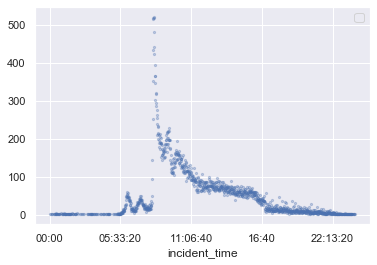

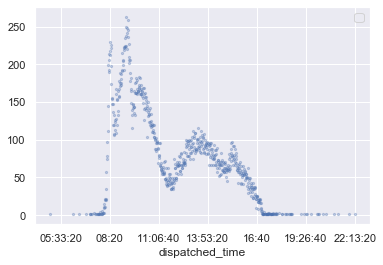

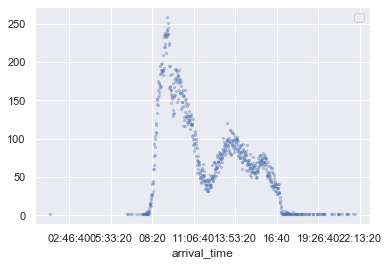

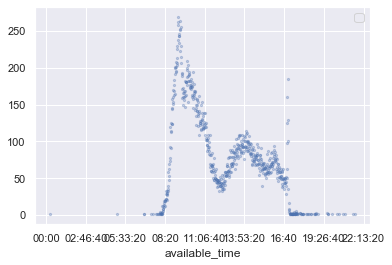

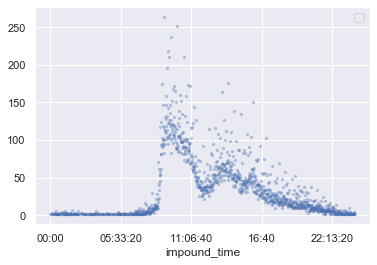

In [130]:
for col in time_cols:
    plot_dtcount(df, col, overlap = False, labels = time_cols)

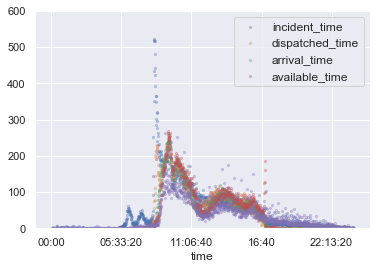

In [131]:
# plotting frequency of each time feature:

for col in time_cols:
    plot_dtcount(df, col
                 , (0, 600)
                 , labels = time_cols)

Around 9am-ish it reaches a peak, then once again rises between 12pm-4pm

#### dates

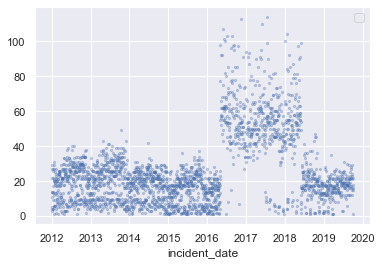

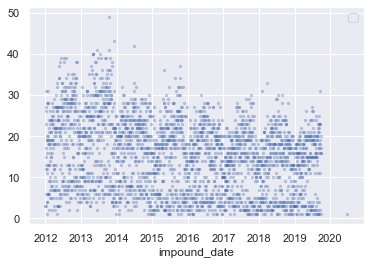

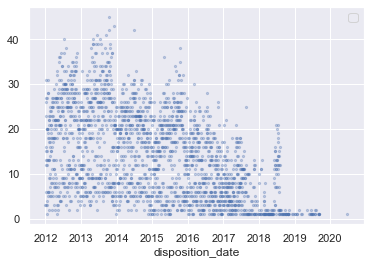

In [132]:
for col in date_cols:
    plot_dtcount(df, col, overlap = False, labels = date_cols)

In [133]:
# date_cols= [col for col in df.columns if 'date' in col]
# date_cols

[]

[]

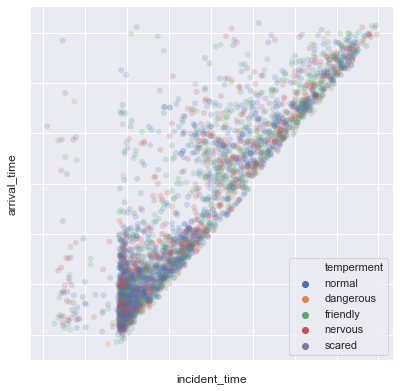

In [134]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
#clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
sns.scatterplot(x='incident_time', y= 'arrival_time'
    #x="incident_date", y="incident_time",
                ,hue="temperment"
                #, size="depth",
                #,palette="ch:r=-.2,d=.3_r"
                #hue_order=clarity_ranking,
                ,sizes=(1, 3), linewidth=0,
                data=df.head(5000), ax=ax, alpha=.2)
ax.set_xticklabels('')
ax.set_yticklabels('')

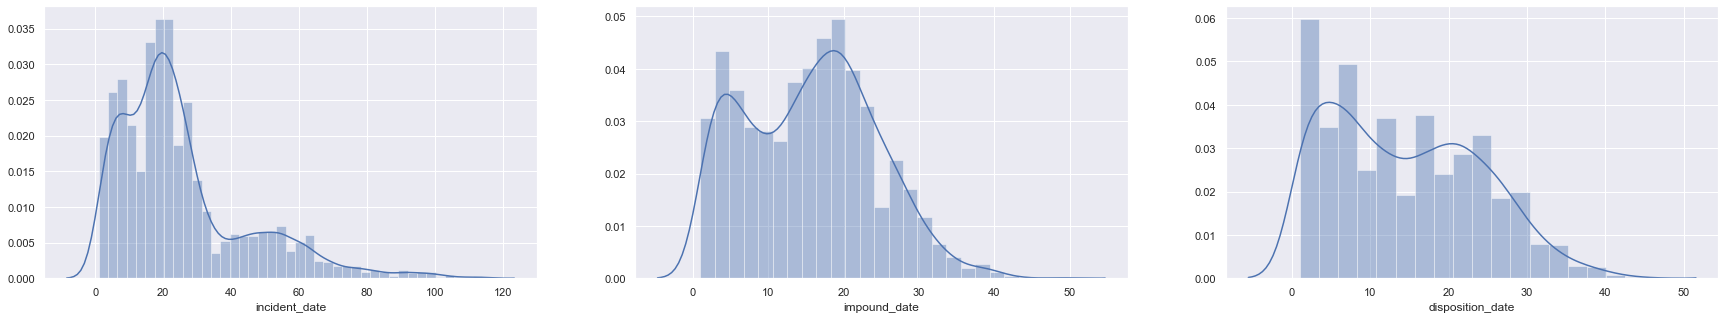

In [135]:
f, axes = plt.subplots(1, 3,figsize=(30,5))
for col, ax in zip(date_cols,(range(0,3))):
    
    sns.distplot((df[col].dropna()).value_counts(), ax=axes[ax]);

#### condition, disposition, size, species, temperment

In [136]:
#value counts of species, size, condition, and temperment features
ssct_df = df[['species', 'size', 'condition', 'temperment', 'disposition']]

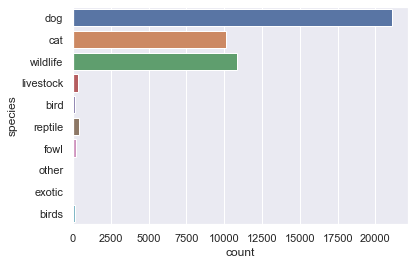

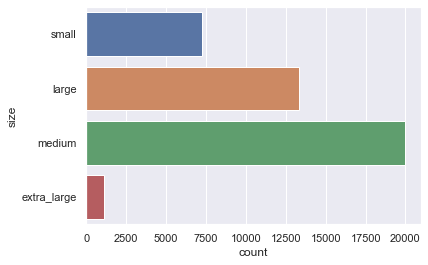

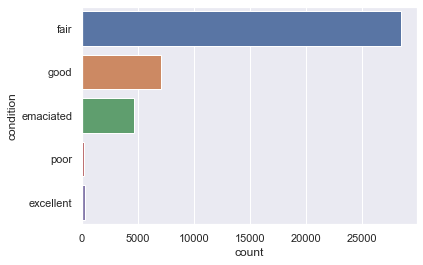

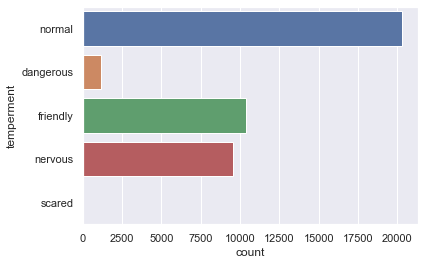

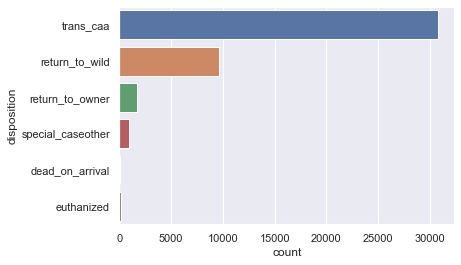

In [137]:
plot_counts(ssct_df)

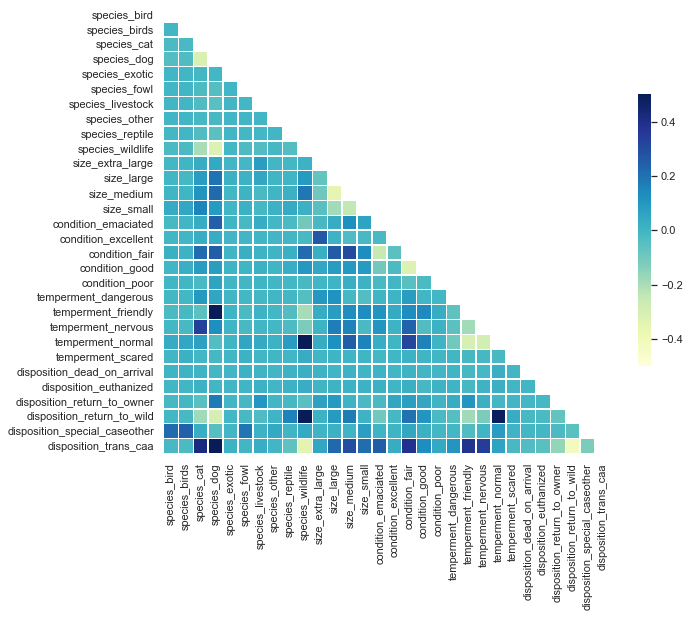

In [138]:
# correlations between species, size, condition, and temperment
corr_plot(ssct_df, minv=-.5, maxv=.5)

# __data prep for model__

In [162]:
def model_report(model): 
    
    print("\nClassification Report:")
    print(classification_report(actuals, predictions))
    
    print('\nConfusion matrix:'.format(accuracy_score))
    display(pd.DataFrame(confusion_matrix(y_test, predictions)
                         ,columns=['pred dangerous','pred friendly', 'pred nervous', 'pred normal']
                         , index=['actual dangerous', 'actual friendly', 'actual nervous', 'actual normal']
                        ))
    

## modeling

### data prep

In [184]:
df1.head()

,incident_date,incident_time,dispatched_time,arrival_time,available_time,complainant_street,equipment_number,impound_date,impound_time,location,...,temperment,disposition,disposition_date,service_type,inc_dt,imp_dt,inc_to_imp,weekday,month,wht
1,2012-01-01,14:12:00,NaN,NaN,NaN,sherwood,nan,2012-01-01,14:12:00,4041_sherwood,...,normal,trans_caa,2012-01-01,bite_case_loose,2012-01-01 14:12:00,2012-01-01 14:12:00,0 days,6,1,NaN
2,2012-01-01,15:04:00,NaN,NaN,NaN,richmond,nan,2012-01-01,15:04:00,2310_richmond,...,dangerous,trans_caa,2012-01-01,dangerous_animal_sit,2012-01-01 15:04:00,2012-01-01 15:04:00,0 days,6,1,NaN
3,2012-01-01,16:51:00,NaN,NaN,NaN,stearns,nan,2012-01-14,16:51:00,5162_stearns,...,friendly,trans_caa,2012-01-14,trapped_animal,2012-01-01 16:51:00,2012-01-14 16:51:00,13 days,6,1,NaN
4,2012-01-02,08:34:00,NaN,NaN,NaN,sunset,nan,2012-01-02,08:34:00,10922_sunset,...,nervous,trans_caa,2012-01-02,trapped_animal,2012-01-02 08:34:00,2012-01-02 08:34:00,0 days,0,1,NaN
5,2012-01-02,08:40:00,NaN,NaN,NaN,anselmo,nan,2012-01-02,08:40:00,8600_anselmo,...,nervous,trans_caa,2012-01-02,dangerous_animal_sit,2012-01-02 08:40:00,2012-01-02 08:40:00,0 days,0,1,NaN


In [140]:
# cleaned data saved to copy
df1 = df.copy()

In [142]:
# df.columns

Index(['incident_date', 'incident_time', 'dispatched_time', 'arrival_time',
       'available_time', 'complainant_street', 'equipment_number',
       'impound_date', 'impound_time', 'location', 'municipality', 'zip_code',
       'species', 'breed', 'size', 'color', 'condition', 'temperment',
       'disposition', 'disposition_date', 'service_type', 'inc_dt', 'imp_dt',
       'inc_to_imp', 'weekday', 'month', 'wht'],
      dtype='object')

In [143]:
df= df[['zip_code', 'species', 'breed', 'size', 'color', 'condition', 'temperment', 'weekday', 'month'
       ,'service_type']]

In [144]:
df= df.replace("nan", np.NaN)
df= df.replace('', np.NaN)

In [145]:
df["temperment"]=df['temperment'].replace("nan", np.NaN)
df["temperment"]=df['temperment'].replace("unknown", np.NaN)
df["temperment"]= df['temperment'].replace("scared", 'nervous')
df.dropna(axis=0, inplace=True)

In [146]:
df.dropna(axis=0, inplace=True)
df = df.reset_index()

In [141]:
df

,incident_date,incident_time,dispatched_time,arrival_time,available_time,complainant_street,equipment_number,impound_date,impound_time,location,...,temperment,disposition,disposition_date,service_type,inc_dt,imp_dt,inc_to_imp,weekday,month,wht
1,2012-01-01,14:12:00,NaN,NaN,NaN,sherwood,nan,2012-01-01,14:12:00,4041_sherwood,...,normal,trans_caa,2012-01-01,bite_case_loose,2012-01-01 14:12:00,2012-01-01 14:12:00,0 days 00:00:00,6,1,NaN
2,2012-01-01,15:04:00,NaN,NaN,NaN,richmond,nan,2012-01-01,15:04:00,2310_richmond,...,dangerous,trans_caa,2012-01-01,dangerous_animal_sit,2012-01-01 15:04:00,2012-01-01 15:04:00,0 days 00:00:00,6,1,NaN
3,2012-01-01,16:51:00,NaN,NaN,NaN,stearns,nan,2012-01-14,16:51:00,5162_stearns,...,friendly,trans_caa,2012-01-14,trapped_animal,2012-01-01 16:51:00,2012-01-14 16:51:00,13 days 00:00:00,6,1,NaN
4,2012-01-02,08:34:00,NaN,NaN,NaN,sunset,nan,2012-01-02,08:34:00,10922_sunset,...,nervous,trans_caa,2012-01-02,trapped_animal,2012-01-02 08:34:00,2012-01-02 08:34:00,0 days 00:00:00,0,1,NaN
5,2012-01-02,08:40:00,NaN,NaN,NaN,anselmo,nan,2012-01-02,08:40:00,8600_anselmo,...,nervous,trans_caa,2012-01-02,dangerous_animal_sit,2012-01-02 08:40:00,2012-01-02 08:40:00,0 days 00:00:00,0,1,NaN
6,2012-01-02,10:21:00,NaN,NaN,NaN,avis,nan,2012-01-02,10:21:00,9307_avis,...,normal,trans_caa,2012-01-02,trapped_animal,2012-01-02 10:21:00,2012-01-02 10:21:00,0 days 00:00:00,0,1,NaN
7,2012-01-02,10:41:00,NaN,NaN,NaN,perkins,11,2012-01-02,10:41:00,10300_perkins,...,normal,return_to_wild,2012-01-02,trapped_animal,2012-01-02 10:41:00,2012-01-02 10:41:00,0 days 00:00:00,0,1,NaN
8,2012-01-02,11:12:00,NaN,NaN,NaN,perkins,19,2012-01-02,11:12:00,10300_perkins_rd,...,NaN,return_to_wild,2012-01-02,trapped_animal,2012-01-02 11:12:00,2012-01-02 11:12:00,0 days 00:00:00,0,1,NaN
9,2012-01-02,12:05:00,NaN,NaN,NaN,fieldcrest,nan,2012-01-02,12:05:00,10400_fieldcrest,...,friendly,trans_caa,2012-01-02,trapped_animal,2012-01-02 12:05:00,2012-01-02 12:05:00,0 days 00:00:00,0,1,NaN
10,2012-01-02,13:22:00,NaN,NaN,NaN,iroquois,nan,2012-01-02,13:22:00,3058_iroquois,...,normal,trans_caa,2012-01-02,injured,2012-01-02 13:22:00,2012-01-02 13:22:00,0 days 00:00:00,0,1,NaN


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18080 entries, 11126 to 63444
Data columns (total 10 columns):
zip_code        18080 non-null object
species         18080 non-null object
breed           18080 non-null object
size            18080 non-null object
color           18080 non-null object
condition       18080 non-null object
temperment      18080 non-null object
weekday         18080 non-null int64
month           18080 non-null int64
service_type    18080 non-null object
dtypes: int64(2), object(8)
memory usage: 1.5+ MB


In [148]:
df = df.astype(object)

In [149]:
df.head()

,zip_code,species,breed,size,color,condition,temperment,weekday,month,service_type
11126,70739.0,dog,pit,large,wht,fair,normal,3,8,owner_signed_release
14170,70805.0,dog,pit,medium,"bndle,wht",good,friendly,4,12,owner_signed_release
14339,70812.0,dog,mixed,small,"tn,wht",good,friendly,2,1,owner_signed_release
15101,70802.0,dog,pit,large,red,fair,normal,3,2,owner_signed_release
15202,70816.0,dog,labrador,large,yel,fair,friendly,2,3,bite_case


In [150]:
df.temperment.value_counts()

normal       9119
friendly     4576
nervous      3892
dangerous     493
Name: temperment, dtype: int64

In [151]:
#df['temperment'] = df['temperment'].astype('object')

In [152]:
df.info

<bound method DataFrame.info of       zip_code   species                         breed    size      color  \
11126  70739.0       dog                           pit   large        wht   
14170  70805.0       dog                           pit  medium  bndle,wht   
14339  70812.0       dog                         mixed   small     tn,wht   
15101  70802.0       dog                           pit   large        red   
15202  70816.0       dog                      labrador   large        yel   
15295  70791.0       dog               german_shepherd   large  bk,gry,tn   
16236  70816.0  wildlife                        possum  medium     bk,gry   
18499  70816.0       dog                           pit  medium  bk,br,wht   
20125  70819.0       dog                      labrador  medium         br   
21213  70806.0       dog                       terrier  medium     bk,wht   
21785  70806.0       cat                           dsh   large    wht,yel   
21788  70818.0  wildlife                    

In [154]:
# assign target accident severity
y = df["temperment"]

#remove target from features
df.drop(columns= ['temperment'], axis=1, inplace=True)

In [155]:
# dummy categorical features
col_list = list(df.select_dtypes(include=['object']).columns)

# create dummies for categorical features, assign to X
df = pd.DataFrame(pd.get_dummies(data=df,columns=col_list
                           , drop_first=True
                   , prefix=col_list))
X = df

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=3)

### model

#### logreg base

In [186]:
##### Train model
clf_0 = LogisticRegression().fit(X, y)
 
# Predict on training set
pred_y_0 = clf_0.predict(X)

In [187]:
print( accuracy_score(pred_y_0, y) )

0.6542035398230088


In [188]:
print( np.unique( pred_y_0 ) )

['dangerous' 'friendly' 'nervous' 'normal']


#### resampling

#### random forest

In [159]:
pipe_rf = Pipeline([('rf_model', RandomForestClassifier(random_state=3))])

In [160]:
#initialize and fit random forest
rf_model = RandomForestClassifier(random_state=3)
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)
actuals = y_test

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [163]:
model_report(rf_model)


Classification Report:
              precision    recall  f1-score   support

   dangerous       0.32      0.07      0.12        99
    friendly       0.51      0.66      0.58       915
     nervous       0.50      0.40      0.44       778
      normal       0.72      0.71      0.71      1824

    accuracy                           0.61      3616
   macro avg       0.51      0.46      0.46      3616
weighted avg       0.61      0.61      0.60      3616


Confusion matrix:


,pred dangerous,pred friendly,pred nervous,pred normal
actual dangerous,7,20,45,27
actual friendly,0,607,76,232
actual nervous,11,214,310,243
actual normal,4,339,195,1286


In [164]:
print(rf_model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


In [165]:
# set random search params
# no of trees
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 10, num = 1)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [ 0.01,0.1,3]
# Minimum number of samples required at each leaf node
min_samples_leaf = [.01,3, 10,50]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
#pprint(random_grid)

In [166]:
# fit and search random param combinations
rf_random = RandomizedSearchCV(estimator = rf_model
                               , param_distributions = random_grid
                               , n_iter = 50, cv = 5, verbose=2
                               , random_state=3, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   56.2s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [167]:
rf_random.best_params_

{'n_estimators': 375,
 'min_samples_split': 0.01,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

In [169]:
# grid search params
param_grid_rf = [
    {'rf_model__criterion': ['entropy','gini'],
    'rf_model__n_estimators': [300,375,400],
    #'rf_model__max_depth': [None],
    'rf_model__min_samples_split': [0.001,0.01, 0.1],
    'rf_model__min_samples_leaf': [2,3,4],
     'rf_model__max_features':['auto', 'sqrt'],
     'rf_model__bootstrap':[False, True]
    }
]

# grid search
gs_rf = GridSearchCV(estimator=pipe_rf,
                    param_grid=param_grid_rf,
                    scoring='accuracy',
                    cv=3, n_jobs=-1, verbose=2)

# fitting grid search
gs_rf.fit(X_train, y_train)

# best parameters
print('best accuracy: {:.4}%'.format(gs_rf.best_score_ * 100))
print('params:\n', gs_rf.best_params_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 35.6min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 35.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('rf_model',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                         

best accuracy: 64.59%
params:
 {'rf_model__bootstrap': False, 'rf_model__criterion': 'entropy', 'rf_model__max_features': 'auto', 'rf_model__min_samples_leaf': 2, 'rf_model__min_samples_split': 0.01, 'rf_model__n_estimators': 375}


In [171]:
# fitting model using best params
rf_gs_model = RandomForestClassifier(
                                    bootstrap= True
                                     ,criterion= 'entropy'
                                     ,max_features = 'auto'
                                     ,min_samples_leaf = 2
                                     , min_samples_split = 0.01
                                     , n_estimators = 375
                                    )
#                                 (criterion='entropy'
#                                  , max_depth=None
#                                  , min_samples_leaf=5
#                                  , min_samples_split=120
#                                  , n_estimators=250
#                                  #, max_features= 'auto'
#                                  , bootstrap= True
#                                     )
rf_gs_model.fit(X_train, y_train)

predictions = rf_gs_model.predict(X_test)
actuals = y_test

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=0.01,
                       min_weight_fraction_leaf=0.0, n_estimators=375,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [180]:
# new model report
model_report(rf_gs_model)


Cross Validation Scoring:

train score: 66.74%
test score: 63.11%
cross val score: 63.02%

Classification Report:
              precision    recall  f1-score   support

   dangerous       0.75      0.03      0.06        99
    friendly       0.50      0.81      0.62       915
     nervous       0.55      0.39      0.45       778
      normal       0.79      0.68      0.73      1824

    accuracy                           0.63      3616
   macro avg       0.65      0.48      0.46      3616
weighted avg       0.66      0.63      0.62      3616


Confusion matrix:


,0,1,2,3
0,3,26,50,20
1,0,740,40,135
2,1,294,300,183
3,0,428,157,1239


NameError: name 'false_positive_rate' is not defined

<Figure size 360x288 with 0 Axes>

In [179]:
def model_report(model): 
    
    print('\nCross Validation Scoring:\n')
    
    train_score = model.score(X_train, y_train)
    print("train score: {:.4}%".format(train_score * 100))

    test_score = model.score(X_test, y_test)
    print("test score: {:.4}%".format(test_score * 100))

    cv_score = np.mean(cross_val_score(model, X, y, cv=3))
    print("cross val score: {:.4}%".format(cv_score * 100))

#     false_positive_rate, true_positive_rate, thresholds = roc_curve(actuals, predictions)
#     roc_auc = auc(false_positive_rate, true_positive_rate)
#     print("AUC  : {:.4}%\n".format(roc_auc * 100))
    

    print("\nClassification Report:")
    print(classification_report(actuals, predictions))
    
    print('\nConfusion matrix:'.format(accuracy_score))
    display(pd.DataFrame(confusion_matrix(y_test, predictions)))
             #    columns=['pred non', 'pred fatal'], index=['actual non', 'actual fatal'])
    
    
    
    # AUC plot
    plt.figure(figsize=(5, 4))
    plt.plot(false_positive_rate, true_positive_rate, color='darkorange',
         label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
plot_feats(rf_gs_model)

# __IGNORE__

In [ ]:
# how much data would be sacrificed if dropping 'unknown'
# len(df[~df.eq('unknown').any(1)])/ len(df)

In [ ]:
#how much data would remain of df if drop na and 'unknowns'
# len(df.dropna()[~df.eq('unknown').any(1)])/len(df)

In [ ]:
# # drop rows with any unknowns
# df = df[~df.eq('unknown').any(1)]

In [ ]:
#df.drop_duplicates(subset=['impound_number', 'species', 'breed', 'service_type', 'incident_date'
#                         , 'color', 'complainant_street', 'disposition', 'disposition_officer'
#                        , 'location', 'complainant_street'], keep= 'last', inplace=True, ignore_index=True)

In [ ]:
# # removing columns with more than 1/3 missing data
# df.dropna(axis=1, thresh=(len(df)//1.5), inplace=True)

#df = df.dropna(axis=0)

In [ ]:
# # DELETE THIS CELL--comparing distribution of time features(**NEEDS WORK**)

# comp_counts(time_cols, time_cols)

# f, axes = plt.subplots(1, 5,figsize=(30,5))
# plt.xlim(-5,50)

# for col, ax in zip(time_cols,(range(0,5))):
#     sns.distplot((df[col].dropna().value_counts()), ax=axes[ax])

In [ ]:
# # sorting rows by number of nas per row descending
# df = df.iloc[df.isnull().sum(axis=1).mul(-1).argsort()]

In [ ]:
# # dropping duplicate file number rows, keeping the one with least nas
# df = df.loc[df.notnull().sum(1).groupby(df.file_number).idxmax()]

In [ ]:
# # how many addresses/ incident count
# df_loc = df[['incident_date', 'location']].dropna().reset_index()
# print (df_loc.groupby('incident_date')['location'].nunique().value_counts())

In [ ]:
# #replacing alternate spellings of same breed- replaced with other methods
#df['breed'] = df['breed'].apply(lambda x: x.replace('bulldog_(english)', 'bulldog_english'))
#df['breed'] = df['breed'].apply(lambda x: x.replace('chow_chow', 'chow'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('boston_terrier', 'boston'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('poodle_-standard', 'poodle'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('basset_hound', 'basset'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('rottweiller', 'rott'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('rottweiler', 'rott'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('pit_bull', 'pitbull'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('pitbull', 'pit'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('_german_shepherd', 'german_shepherd'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('_retriever', 'retriever'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('labrador_retriever', 'labrador'))
# df = df.apply(lambda x: x.replace('poodle_(min/toy)', 'poodle_min/toy'))
# df = df.apply(lambda x: x.replace('poodle_standard', 'poodle'))
# df = df.apply(lambda x: x.replace('catahoula_hound', 'catahoula'))
# df = df.apply(lambda x: x.replace('english_bulldog', 'bulldog_english'))
# df = df.apply(lambda x: x.replace('bulldog_(french)', 'bulldog_french'))
# df = df.apply(lambda x: x.replace('boer', 'boxer'))
# df = df.apply(lambda x: x.replace('fo_terrier', 'fox_terrier'))
# df = df.apply(lambda x: x.replace('shar_pei', 'sharpei'))
# df = df.apply(lambda x: x.replace('alaskan__malamute','alaskan_malamute'))
# df = df.apply(lambda x: x.replace('brittany_spaniel', 'brittany'))
# df = df.apply(lambda x: x.replace('fohound', 'foxhound'))
# df = df.apply(lambda x: x.replace('other', 'unknown'))
# #df = df.apply(lambda x: x.replace('nan', np.NaN))

In [ ]:
# # profile report
# pandas_profiling.ProfileReport(df)

# observations from pandas profile report:

# - lots of columns missing data

# unneeded columns:
# - ARRIVAL TIME- has most at 00:00
# - AVAILABLE TIME- most at 00:00
# - CALL TAKER
# - COLLAR
# - COLLAR COLOR
# - IMPOUND NUMBER
# - INCIDENT TIME
# - PET NAME
# - REMARKS(too little data provided(3%), existing data doesn't appear to be useful)
# - VACCINATION DATE(99.5% missing)
# - VACCINATION NUMBER
# - ZIP CODE


# columns needing work or consider exclusion:
# - AGE 55% missing
# - X in front of BREED- cross breed?
# - CONDITION 31% missing
# - DISPATCHED OTHER and DISPATCHED SITUATION- what does it mean?
# - EQUIPMENT NUMBER - what does it mean?
# - FILE NUMBER - probably not useful
# - REQUEST TYPE and SERVICE CODE appear to provide same content
# - SEX contains only 37% M or F, other data missing or irregular
# - SIZE 30% missing
# - SPECIES 28% missing
# - TEMPERMENT 30% missing
# - COLOR 29% missing
# - LOCATION and COMPLAINT STREET can be merged somehow?


In [ ]:
#percent missing values per column
# round(df.isna().sum()/len(df)*100)

In [ ]:
# nevermind- replaced above with loop for each name column

# #how many dispatchers typically work per day?

# # df with incident time and dispatcher dropping nas
# df2 = df[['incident_date', 'dispatcher']].dropna().reset_index()

# # grouping df by unique count of dispatchers per day
# # then seeing how many days they have each given number of dispatchers
# # print ('number of dispatchers/ number of days\n',df2.groupby('incident_date')['dispatcher'].nunique().value_counts())

# # how many days does each dispatcher work/ appear on indicent report
# df3 = df[['incident_date', 'dispatcher']].dropna().reset_index()

# print (df3.groupby('dispatcher')['incident_date'].nunique())

In [ ]:
# lower casing and eliminating characters, moved to later in cleaning
# for now, saved for later, but could also do this to only select columns to prevent issues

# df = df.apply(lambda x: x.astype(str).str.lower())
# df = df.apply(lambda x: x.astype(str).str.strip())
# df = df.apply(lambda x: x.astype(str).str.replace(' ', '_'))

In [ ]:
# for col in cdsst:
#     df[col] = df[col].apply(lambda x: x.replace(' ', '_'))

# for col in cdsst:
#     clean_str(col)

# #
# for col in cdsst:
#     df[col] = df[col].astype(str)
#     df[col] = df[col].str.strip()
#     df[col] = df[col].apply(lambda x: x.replace(' ', '_'))
#     df[col] = df[col].str.lower()
#     remove_numpunc(col, pattern='[^A-Za-z_]+')

In [ ]:
# replaced with regex
#characters = ('*',"'",'/','=',',','�','_',"'", '-', '(', ')', '.', '\\', ',,', ',,,', '_/_', ' ', '  ', '//','&')

#edit_replace(characters, ',')
#df['color'] = df['color'].str.strip()

In [ ]:
# pattern = '[^A-Za-z^/]+'
# list = [re.sub(pattern, '', i) for i in df.color] 
# list

In [ ]:
# # # how much data would remain after removing columns with more than 1/3 missing data
# df_drop_cols = (df.dropna(axis=1, thresh=(len(df))//1.5))
# len(df_drop_cols.columns)/ len(df.columns)
# #(len(df.dropna(axis=1, thresh=(len(df))//1.5)).columns)/len(df.columns)

# # # how much would then be left after then removing rows with more than 20 missing data
# len(df_drop_cols.dropna(axis=0, thresh=(20)))/len(df)

In [ ]:
# # looking at strings separated to evaluate how to edit; priority in high value counts
# results = Counter()
# df['color'].str.split(',').apply(results.update)
# pp.pprint (results)

In [ ]:
## replacing/seperating color strings
# # tan and white
# edit_replace(('tanwht'), 'tan,wht')

# # black and white
# edit_replace(('blkwht','blkwt'), 'blk,wht')

# # grey and white
# edit_replace(('graywhite','grywht','whtgry','greywht'), 'gry,wht')

# # black and brown
# edit_replace(('brnblk'), 'br,bl')

# # brown and white
# edit_replace(('brwnwht','whtbrwn'), 'brn,wht')

# # grey and black
# edit_replace(('gryblk'), 'gry,blk')

# # green and yellow
# edit_replace(('greenyellow'), 'grn,yel')

# # grey and yellow
# edit_replace(('gryyellow'), 'grey,yell')

# edit_replace(('brwnbkwh'), 'brn,blk,wht')

In [ ]:
#limiting colors to selected and also only with certain value count(no longer using this method)

#colors = ('wht', 'bk', 'gry', 'br', 'tn', 'spot', 'or', 'tab', 'blue', 'red', 'ylw', 'calico', 'tri', 'green', 'multi', 'dark', 'light', 'pink')

#ndf = df[~df['color'].isin([colors])]

#ndf = ndf[ndf.color.value_counts()>=20]

#ndf.color.value_counts()

In [ ]:
# def clean_str(col, df=df):
# #    for col in cols:
#     df[col] = df[col].astype(str)
#     df[col] = df[col].str.strip()
#     df[col] = df[col].str.lower()
# #     if pattern= pattern= '[^A-Za-z_]+':
# #         df[col] = df[col].apply(lambda x: x.replace(' ', '_'))
#     # regex for letters and '_' only, unless pattern reassigned:
# #     if regex:
# #         pattern = pattern
# #         df[col] = [re.sub(pattern, '', i) for i in df[col]] 
# #     return df[col]

# # #         #print('--',col.capitalize(),'--\n',df[col].value_counts(),'\n')

In [ ]:
# # maybe creating list of dog breeds, if wanting to analyze seperately from other animals
# dogs = ('pit', 'labrador', 'terrier', 'german_shepherd', 'shepherd', 'chihuahua', 'hound', 'rott'
#         , 'boxer', 'beagle', 'catahoula', 'chow', 'shih_tzu', 'dachshund', 'retriever', 'husky'
#         , 'yorkshire_terrier', 'american_bulldog', 'poodle', 'australian_shepherd', 'poodle_min/toy'
#         , 'collie', 'pomeranian', 'mastiff', 'golden_retriever', 'maltese', 'cocker_spaniel', 'healer'
#         , 'doberman_pinscher', 'miniature_pinscher', 'border_collie', 'schnauzer', 'great_dane'
#         , 'rat_terrier', 'akita', 'jack_russel_terrier', 'bulldog_english', 'spaniel', 'doberman'
#         , 'pug', 'pekingese', 'basset', 'dalmation', 'boston', 'weimeraner', 'lhasa_apso', 'pointer'
#         , 'rhodesian_ridgeback', 'sharpei', 'great_pyrenees', 'bull_terrier', 'bichons_frise', 'bloodhound'
#         , 'saint_bernard', 'springer_spaniel', 'sheepdog', 'alaskan_malamute', 'scottish_terrier'
#         , 'cairn_terrier', 'staffordshire_bull_terrier', 'setter', 'sheltie', 'cane_corso', 'whippet'
#         ,  'basenji', 'spitz', 'greyhound', 'walker_hound', 'siberian_husky', 'west_highland_terrier'
#         , 'american_eskimo', 'bull_mastiff', 'brittany', 'bluetick_hound', 'foxhound', 'australian_cattle'
#         , 'american_staffordshire_terrier', 'bulldog_french', 'australian_blue_heeler', 'bourvier_des_flanders'
#         , 'fox_terrier', 'wolf', 'coonhound', 'norweigian_elkhound')

In [ ]:
# # (to maximize notebook screen size):
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
# #sns overlapping distplot
# def comp_counts(cols, labels):
#     sns.set(rc={'figure.figsize':(10, 5)})
#     plt.xlim(-5,100)
#     plt.title("times")
#     for col, label in zip(cols, labels):
#         sns.distplot(df[col].value_counts(), label=label, bins=40)
#     plt.legend()
#     plt.show();

In [ ]:
# [re.sub('[^A-Za-z/]+','', i) for i in df.breed]

# # # removing digits
# # def remove(list): 
# #     pattern = '[0-9]'
# #     list = [re.sub(pattern, '', i) for i in list] 
# #     return list
# # df['color'] = (remove(df.color))

# # replacing extra punctuations with '/'  (** look into more efficient regex methods**)
# characters = ('�','_',"'", '-', '(', ')', '.', '\\', ',,', ',,,', '_/_', ' ', '  ', '//')

# edit_replace(characters, '/')

##  IGNORE:  *Pet names (just for fun)

Dropping columns with few non-nulls, but curious about Baton Rouge's most common pet names, keeping in mind only 1% of incident reports included a name.

In [ ]:
# df.pet_name.value_counts().head(15)

'Max' and 'Coco' are tied at 17, but most lie within the single digits. One would assume most of these correspond to 'dog' or 'cat' species, do they satisfy that assumption?

In [ ]:
# # percent of names provided in relation to species
# p_names_only = df[['pet_name','species']]
# p_names_only = p_names_only.dropna()
# p_name_ratio = p_names_only['species'].value_counts()/df['species'].value_counts()
# p_name_ratio.plot.bar();

Of the dataset as a whole, these are the percentages of species with names included in reports. It looks like livestock incident reports included names more often than cats. Not surprisingly, dogs overwhelmingly had their names included in the incident reports. 

However, due to the amount of missing data, no justifiable conclusions can be made from this alone. 

___
another 'just for fun' thing:
looking at the disposition of animals with names on report:

In [ ]:
# # percent of names provided in relation to species
# d_names_only = df[['pet_name','temperment']]
# d_names_only = d_names_only.dropna()
# d_name_ratio = d_names_only['temperment'].value_counts()/df['temperment'].value_counts()
# d_name_ratio.plot.bar();

# experimental joining dataset

In [ ]:
# crime_df = pd.read_csv('Baton_Rouge_Crime_Incidents.csv')

In [ ]:
# unemp_df = pd.read_csv('BATO922URN.csv')

In [ ]:
# crime_df.head()

In [ ]:
# crime_df.info()

In [ ]:
# crime_df = pd.read_csv('Baton_Rouge_Crime_Incidents.csv')

In [ ]:
# unemp_df = pd.read_csv('BATO922URN.csv')

In [ ]:
# crime_df.offense_time

In [ ]:
# # removing spaces and lower casing the column names
# crime_df.columns = crime_df.columns.str.lower()
# crime_df.columns = crime_df.columns.str.strip()
# crime_df.columns = crime_df.columns.str.replace(' ', '_')

In [ ]:
# # time columns to list
# time_cols= [col for col in crime_df.columns if 'time' in col]

# # covert time to hour/minute datetime format
# for col in time_cols:
#     crime_df[col] = pd.to_datetime(crime_df[col], errors='ignore', format="%H:%M")
#     #.dt.time

In [ ]:
# impound date + impound time = impound datetime
# crime_df['datetime'] = pd.to_datetime(crime_df['offense_date'].apply(str)+' '+crime_df['offense_time'], errors ='ignore')